# TXMeans by Riccardo Guidotti
**Notebook by Edoardo Gabrielli**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setting-Python-Path" data-toc-modified-id="Setting-Python-Path-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setting Python Path</a></span></li><li><span><a href="#Import-Packages" data-toc-modified-id="Import-Packages-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Packages</a></span><ul class="toc-item"><li><span><a href="#Internal-Packages" data-toc-modified-id="Internal-Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Internal Packages</a></span></li><li><span><a href="#Other-Packages" data-toc-modified-id="Other-Packages-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Other Packages</a></span></li></ul></li><li><span><a href="#Visualize-Data" data-toc-modified-id="Visualize-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualize Data</a></span></li><li><span><a href="#Application-of-algorithm" data-toc-modified-id="Application-of-algorithm-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Application of algorithm</a></span></li></ul></div>

## Setting Python Path

In [39]:
import os, sys, importlib
from os.path import expanduser
from pathlib import Path

# TO DO: Better way to add to PythonPath the package.
home = str(Path.home())

## MODIFY HERE! ##
# This need to point on the folder where you clone the repo (respect to the home...)
Folder_Cloned_In = '/Desktop/Unipi/Data Mining Advanced/fma_metadata/Advanced_Clustering/TX-Means-master' # Change here..
##################

# Full dir name
path_to_lib = home + Folder_Cloned_In

if os.path.isdir(path_to_lib):
    print(f'My Home is: {home}')
    print(f'I cloned in: {path_to_lib}')
    # Add dirs to Python Path 
    sys.path.insert(0, path_to_lib + '/code')
    sys.path.insert(0, path_to_lib + '/code/algorithms')
else:
    print("Can't find Directory.")
    print('For example: you are in')
    print(str(os.getcwd()))

My Home is: /Users/eleonoracocciu
I cloned in: /Users/eleonoracocciu/Desktop/Unipi/Data Mining Advanced/fma_metadata/Advanced_Clustering/TX-Means-master


## Import Packages

### Internal Packages

In [40]:
import algorithms.txmeans
from algorithms.txmeans import TXmeans # The class (like sklearn)
from algorithms.txmeans import remap_items, count_items, sample_size # Util functions
from algorithms.txmeans import basket_list_to_bitarray, basket_bitarray_to_list # Converting(Reverting) to(from) bitarray
from generators.datamanager import read_uci_data # (Convert the data in nice basket format)
from validation.validation_measures import delta_k, purity, normalized_mutual_info_score # Measure of Validation
from validation.validation_measures import entropy, silhouette # Measure of Validation
from algorithms.util import jaccard_bitarray

### Other Packages

In [41]:
import pandas as pd
import numpy as np
import IPython.display as ipd
import datetime
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
import collections
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import pyplot
from sklearn.metrics import silhouette_score, calinski_harabasz_score, silhouette_samples, davies_bouldin_score

In [42]:
def cluster_insight(df):
    
    cluster_diz = pd.DataFrame(columns = ["Studio_Recording", "Live_Recording"], \
                                index = ["Cluster {}".format(str(i)) for i in np.unique(df['Labels'])])
    
    tot_entropies = []
    dim_clusters = []
    max_cluster = 0

    for i in np.unique(df['Labels']):

        cluster_list = list(df[df['Labels'] == i]['album_type'])

        counter = collections.Counter(cluster_list)

        cluster_diz.loc["Cluster {}".format(str(i)), 'Studio_Recording'] = counter[0]
        cluster_diz.loc["Cluster {}".format(str(i)), 'Live_Recording'] = counter[1]

        #cluster_diz.loc["Cluster {}".format(str(i)), 'Tot_Cluster'] = cluster_diz.loc["Cluster {}".format(str(i)), ['Studio_Recording', 'Live_Recording']].sum()

        lista = cluster_diz.loc['Cluster {}'.format(str(i)), ['Studio_Recording', 'Live_Recording']].values.tolist()
        tot = sum(lista)
        cluster_diz.loc["Cluster {}".format(str(i)), 'Tot_Cluster'] = tot
        dim_clusters.append(tot)

        '''
        Entropia singola: -(sommatoria di (pij log2 pij) per tutte le classi all'interno di un cluster.
        --> pij = mij/mj dove mj è il numero di valori nel cluster j e mij è il numero di valori della classe i
        nel cluster j.
        '''
        entropy_single = sum([(x/tot)*math.log2(x/tot) for x in lista if x != 0])
        if entropy_single != 0.0:
            entropy_single*=-1
        cluster_diz.loc["Cluster {}".format(str(i)), 'Entropy'] = "%.4f" %(entropy_single)
        tot_entropies.append(entropy_single)


        '''
        Purity singola: etichetta della classe più frequente/numero di valori nel cluster
        '''
        purity_single = max(lista)/tot
        cluster_diz.loc["Cluster {}".format(str(i)), 'Purity'] = "%.4f" %(purity_single)

        max_cluster += max(lista)


    new_row = pd.Series(cluster_diz[['Studio_Recording', 'Live_Recording', 'Tot_Cluster']].sum(axis=0).astype(int), name = "Total")
    cluster_diz = cluster_diz.append(new_row, ignore_index=False)

    '''
    Entropia complessiva: sommatoria delle entropie di ogni cluster pesate per la dimensione di ogni cluster.
    --> (mj/m) * ej --> dove mj è la dimensione del cluster j e m è il numero totale di punti. 
    '''

    last_tot = cluster_diz.loc['Total', 'Tot_Cluster']
    tot_entropy = 0

    for entropy, dim in zip(tot_entropies, dim_clusters):
        tot_entropy+=(entropy*(dim/last_tot))

    cluster_diz.loc["Total", 'Entropy'] = "%.4f" %(tot_entropy)

    '''
    Purity complessiva: sommatoria delle classi "corrette" (il valore più alto) di ogni cluster, divisa per il
    numero totale di valori.
    '''

    tot_purity = max_cluster/last_tot
    cluster_diz.loc["Total", 'Purity'] = "%.4f" %(tot_purity)



    cluster_diz['Tot_Cluster'] = cluster_diz['Tot_Cluster'].astype(int)

    ipd.display(cluster_diz)

In [43]:
def plot_general_distributions(df):
    
    for column in df.columns:

        if column != 'Labels':

            fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 5))
            cluster_list = []
            list_num_cluster = []

            for num_cluster in np.unique(df['Labels']):
                cluster_list.append(df[df['Labels'] == num_cluster][column])  #distribution
                list_num_cluster.append('Cluster %s' % num_cluster)           #num cluster

            ax[0].hist(cluster_list, label = list_num_cluster)
            ax[0].legend(title="Clusters", bbox_to_anchor = (1, 1.05), loc='upper left', \
                   frameon = True, shadow = True)
            ax[0].set_title(column + " Histogram")

            ax[1].hist(df[column], color = "#B8002E")
            ax[1].set_title(column + " Histogram (Distribution in the whole dataset)")

            fig.tight_layout()
            plt.show()

In [44]:
def analyze_single_clusters(df):
    
    for label in np.unique(df['Labels']):
        
        print("Cluster {}".format(label))
        print()
        
        Studio_0_dataset = df[(df['Labels'] == label) & (df['album_type'] == 0)] #Studio_Recording

        Live_1_dataset = df[(df['Labels'] == label) & (df['album_type'] == 1)]   #Live_Recording

        for column in df.columns:

            if (column != 'Labels' and column != 'album_type'):

                fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 5), sharey = True)

                ax[0].hist(Studio_0_dataset[column], label = 'Studio_Recording', color = "#8AB800")
                ax[0].legend(loc='upper right')
                ax[0].set_title(column + " Histogram - Cluster {}".format(label))

                ax[1].hist(Live_1_dataset[column], label = 'Live_Recording', color = "#FF3D3D")
                ax[1].legend(loc='upper right')
                ax[1].set_title(column + " Histogram - Cluster {}".format(label))

                plt.show()
        print("------------------------------------------------------------------------------------------------------------------")

## Visualize Data

In [45]:
df_categorical = pd.read_csv(path_to_lib + '/df_genres_years.csv', index_col = 0)

In [46]:
df_categorical

,track_genre_top_Hip-Hop,track_genre_top_Pop,track_genre_top_Experimental,track_genre_top_Folk,track_genre_top_Jazz,track_genre_top_Rock,track_genre_top_Electronic,track_genre_top_Spoken,track_genre_top_International,track_genre_top_Soul-RnB,...,track_date_created_year_1,track_date_created_year_2,track_date_created_year_3,track_date_created_year_4,track_date_created_year_5,track_date_created_year_6,track_date_created_year_7,track_date_created_year_8,track_date_created_year_9,track_date_created_year_10
track_id,,,,,,,,,,,,,,,,,,,,,
2,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
10,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
20,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155316,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
155317,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
155318,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [47]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103708 entries, 2 to 155320
Data columns (total 27 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   track_genre_top_Hip-Hop              103708 non-null  int64
 1   track_genre_top_Pop                  103708 non-null  int64
 2   track_genre_top_Experimental         103708 non-null  int64
 3   track_genre_top_Folk                 103708 non-null  int64
 4   track_genre_top_Jazz                 103708 non-null  int64
 5   track_genre_top_Rock                 103708 non-null  int64
 6   track_genre_top_Electronic           103708 non-null  int64
 7   track_genre_top_Spoken               103708 non-null  int64
 8   track_genre_top_International        103708 non-null  int64
 9   track_genre_top_Soul-RnB             103708 non-null  int64
 10  track_genre_top_Blues                103708 non-null  int64
 11  track_genre_top_Classical            10

## Application of algorithm

In [48]:
# We set here the dir to the data (you have to pass to the function that create baskets)
path = path_to_lib + '/'
dataset_name = 'df_genres_years.csv'
filename = path + dataset_name

# Initialize the model
txmeans_model = TXmeans()
# Target Class index (if you have one, otherwise you need to put here an index useless for the clustering)
class_index = 16

# Skip Dataset columns if you want
skipcolumnsindex = set()

# return ([baskets], maps to target index) and maps of every single value in the dataset.
baskets_real_labels, maps = read_uci_data(filename, class_index=class_index, skipcolumnsindex=skipcolumnsindex)

print( dataset_name, len(baskets_real_labels))

# Save baskets and the real labels 
baskets_list = list()
real_labels = list()
count = 0
for basket, label in baskets_real_labels:
    baskets_list.append(basket)
    real_labels.append(label)
    count += 1
    
# Speeding up the Jaccard distance: 
baskets_list, map_newitem_item, map_item_newitem = remap_items(baskets_list)
baskets_list = basket_list_to_bitarray(baskets_list, len(map_newitem_item))

# Get the number of baskets (equal to number of data) 
nbaskets = len(baskets_list)

# Get the number of different item
nitems = count_items(baskets_list)

start_time = datetime.datetime.now()

# Get subsamples of the dataset (in order to speed up)
nsample = sample_size(nbaskets, 0.05, conf_level=0.99, prob=0.5)

# Fit the model
txmeans_model.fit(baskets_list, nbaskets, nitems, random_sample=nsample)

end_time = datetime.datetime.now()
running_time = end_time - start_time

# Get the label and the clusters 
res = txmeans_model.clustering

# Number of iteration of the model for the convergence
iter_count = txmeans_model.iter_count

# Initialize empty predicted labels
pred_labels = [0] * len(real_labels)

# Initialize empty cluster list
baskets_clusters = list()
for label, cluster in enumerate(res):
    # Revert the bitarray transform.
    cluster_list = basket_bitarray_to_list(cluster['cluster']).values()
    for bid, bitarr in cluster['cluster'].items():
        # Labels of every data point
        pred_labels[bid] = label
        # Clusters
        baskets_clusters.append(cluster_list)

# Mesure of "goodness" for clustering algorithm respect to the target attribute
print('delta_k', delta_k(real_labels, pred_labels))
print('normalized_mutual_info_score', normalized_mutual_info_score(real_labels, pred_labels))
print('purity', purity(real_labels, pred_labels))
print('running_time', running_time)

print(f'Num of Clusters: {len(np.unique(np.array(pred_labels)))}')

df_genres_years.csv 103708
delta_k 0
normalized_mutual_info_score 8.718141909607641e-06
purity 0.9365911983646392
running_time 0:01:00.994528
Num of Clusters: 2


In [49]:
delta_k = delta_k(real_labels, pred_labels)
normalized_mutual_info_score = normalized_mutual_info_score(real_labels, pred_labels)
purity = purity(real_labels, pred_labels)

num_clusters = len(np.unique(np.array(pred_labels)))

df_metrics = pd.DataFrame({'N_clusters': num_clusters, 'delta_k': '%.4f'%(delta_k), \
                           'NMI': '%.4f'%(normalized_mutual_info_score), \
                           'Purity': '%.4f'%(purity)}, index = ['Genres, years and seasons'])

In [50]:
df_metrics

,N_clusters,delta_k,NMI,Purity
"Genres, years and seasons",2,0.0000,0.0000,0.9366


You cha also get the cluster's medioids:

In [51]:
txmeans_model.medioids

[68227, 92198]

In [52]:
entropy(res)

0.0

In [53]:
df_categorical_2 = df_categorical.copy()

In [54]:
df_categorical_2['Labels'] = pred_labels

In [55]:
cluster_insight(df_categorical_2)

,Studio_Recording,Live_Recording,Tot_Cluster,Entropy,Purity
Cluster 0,9171,495,9666,0.2915,0.9488
Cluster 1,83012,11030,94042,0.5215,0.8827
Total,92183,11525,103708,0.5001,0.8889


In [56]:
df_to_test = df_categorical[[col for col in df_categorical.columns if col != 'album_type']]

sil = silhouette_score(df_to_test, pred_labels)
        
cal = calinski_harabasz_score(df_to_test, pred_labels)
       
boul = davies_bouldin_score(df_to_test, pred_labels)

print ('Silhouette Score: ', sil)
print ("Calinski - Harabaz Score: ", cal)
print ("Davies - Bouldin Score: ", boul)

Silhouette Score:  0.07799975876320912
Calinski - Harabaz Score:  6044.741130440865
Davies - Bouldin Score:  2.091430919042283


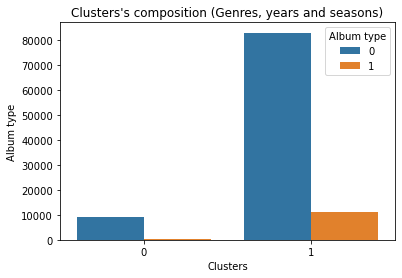

In [57]:
b = sns.countplot(x=df_categorical_2['Labels'], data=df_categorical_2, \
                  hue = df_categorical_2['album_type'])
b.set_xlabel("Clusters")
b.set_ylabel("Album type")
b.set_title("Clusters's composition (Genres, years and seasons)")
b.tick_params()
b.legend_.set_title('Album type')
b.grid(False)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


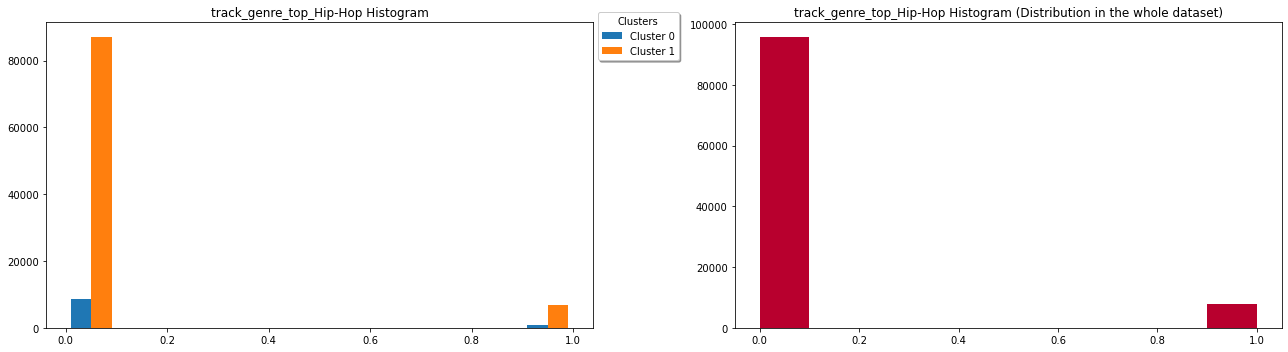

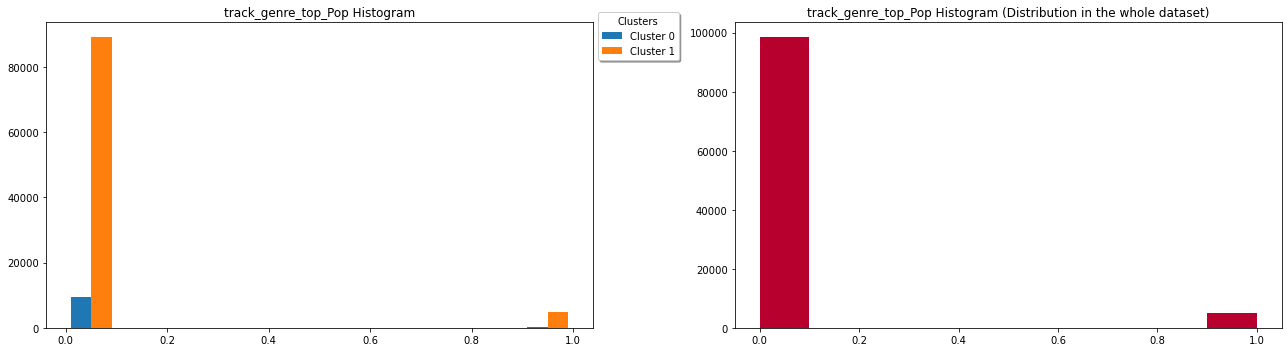

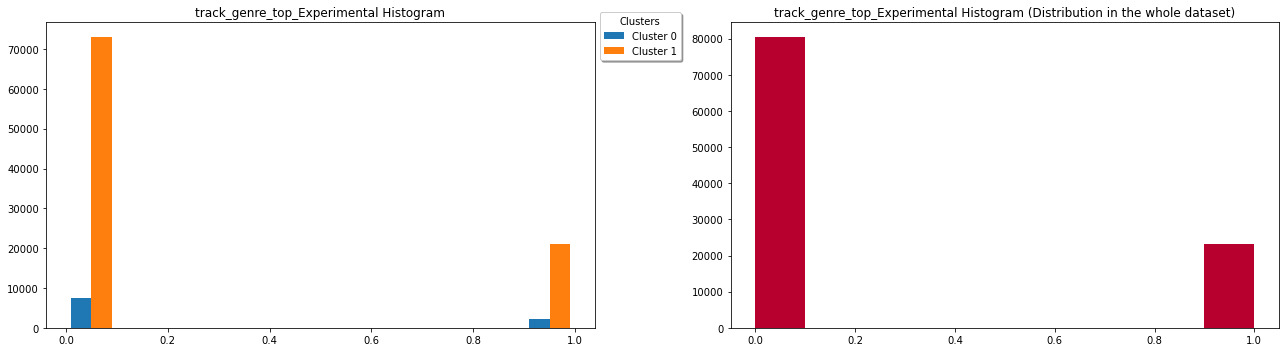

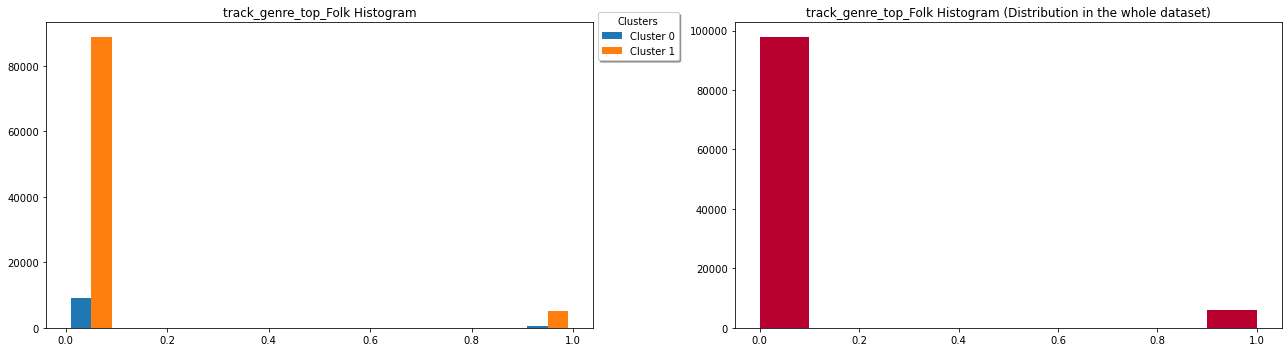

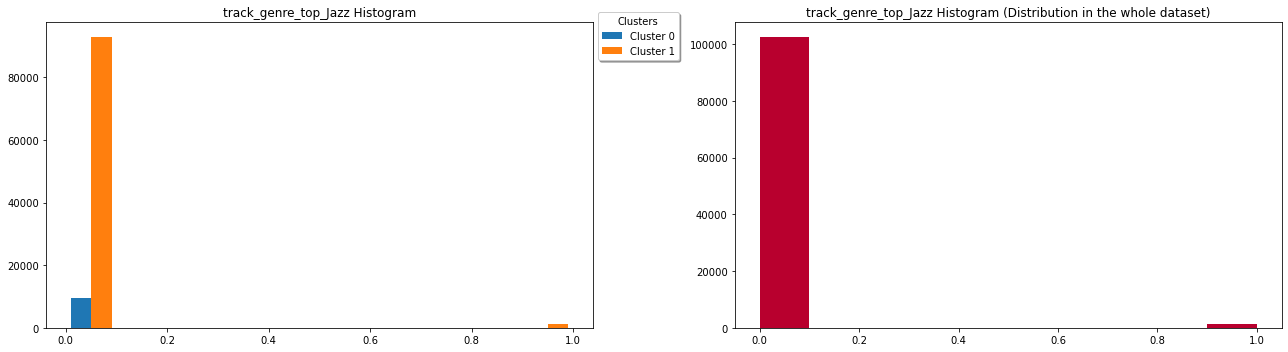

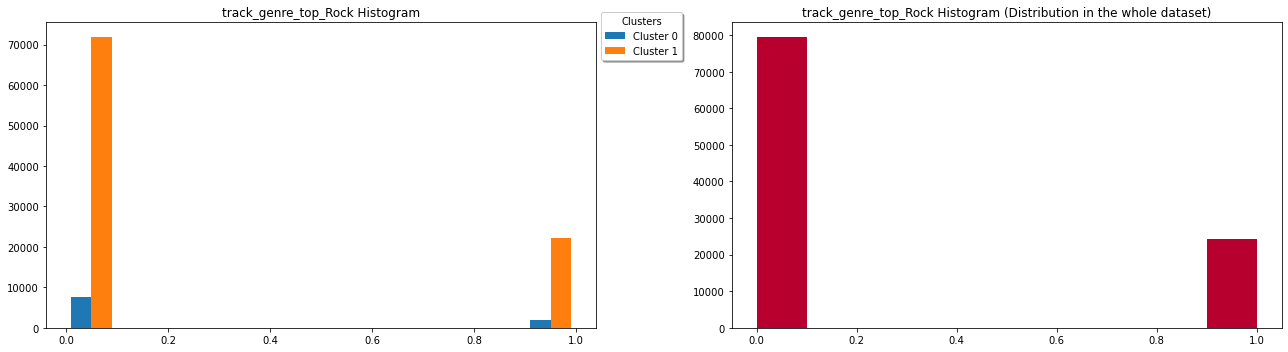

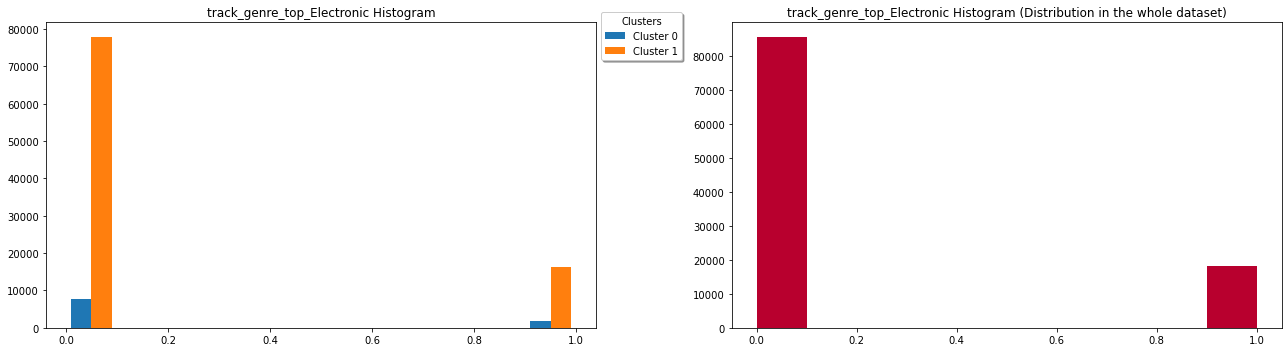

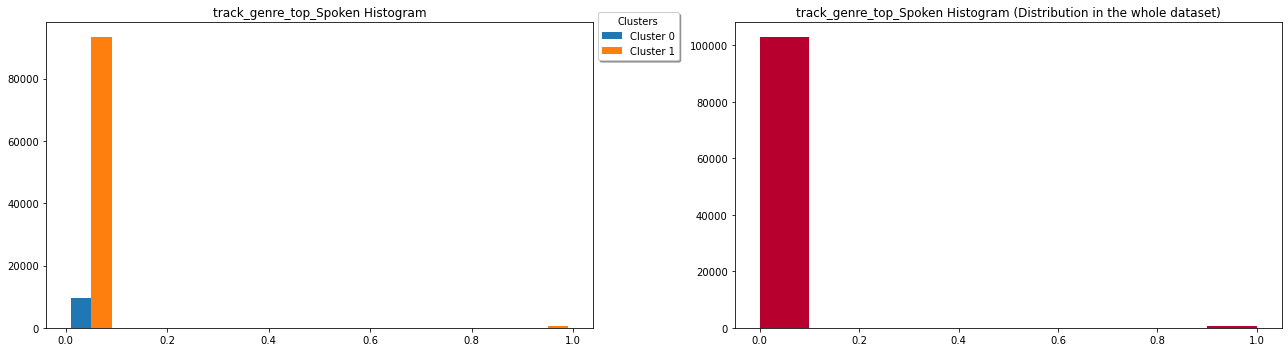

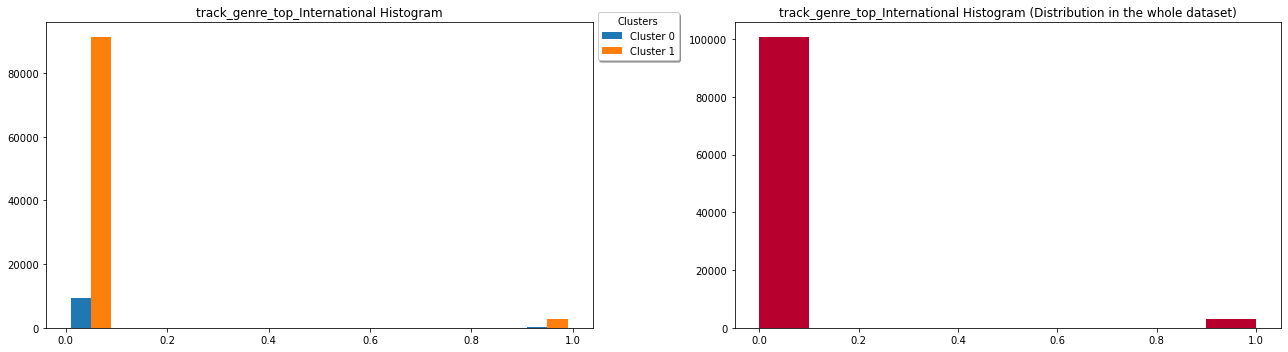

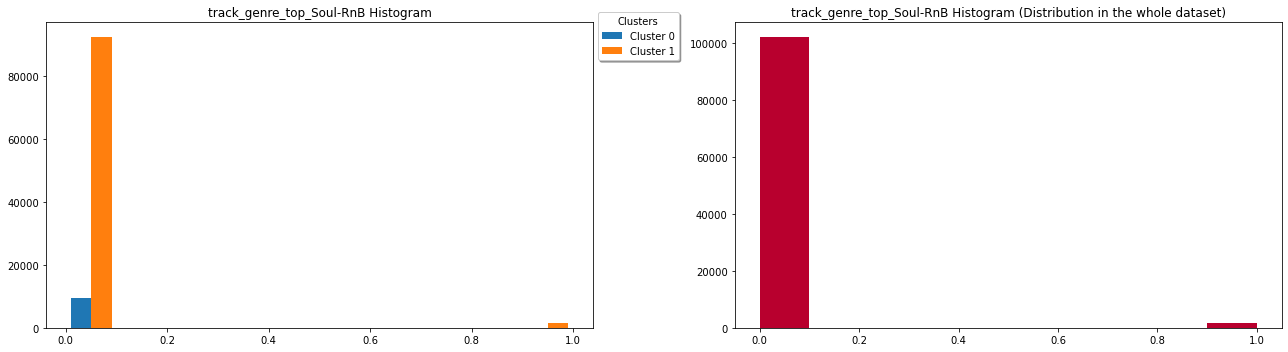

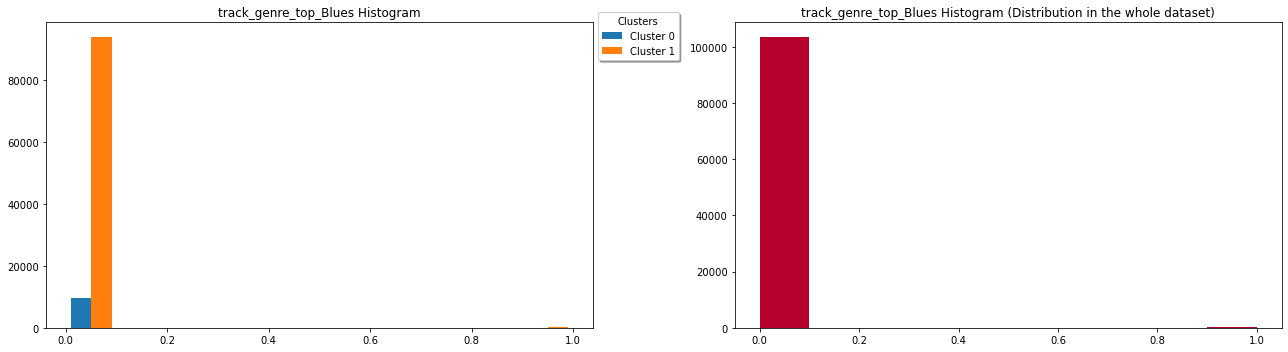

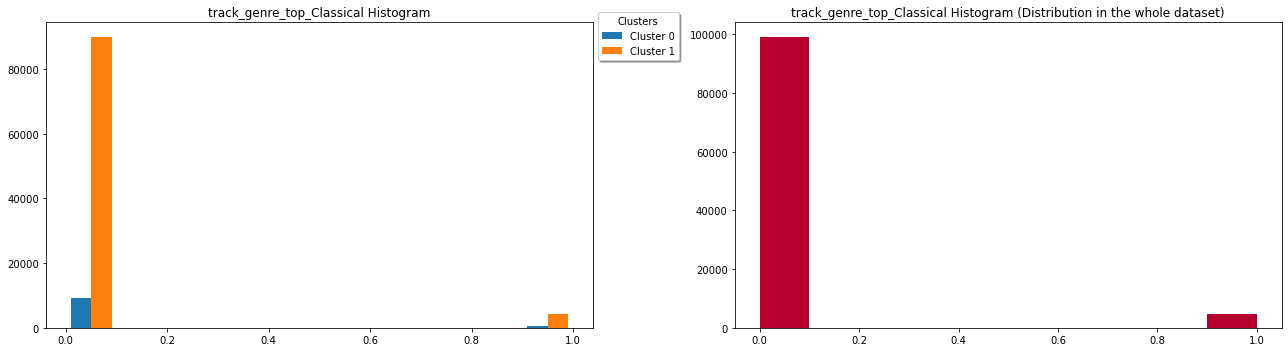

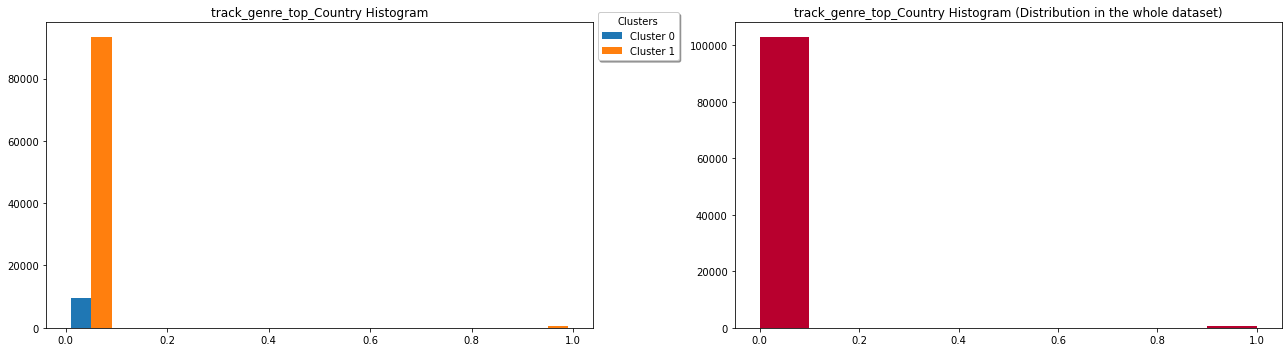

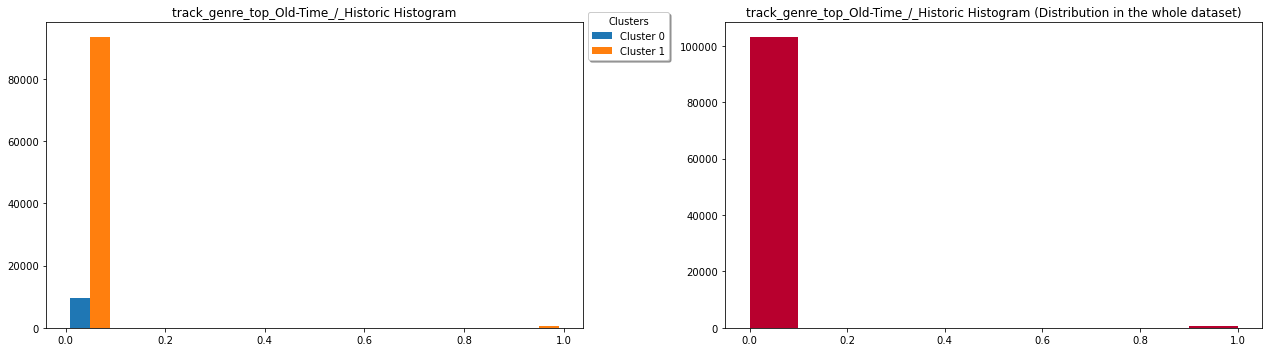

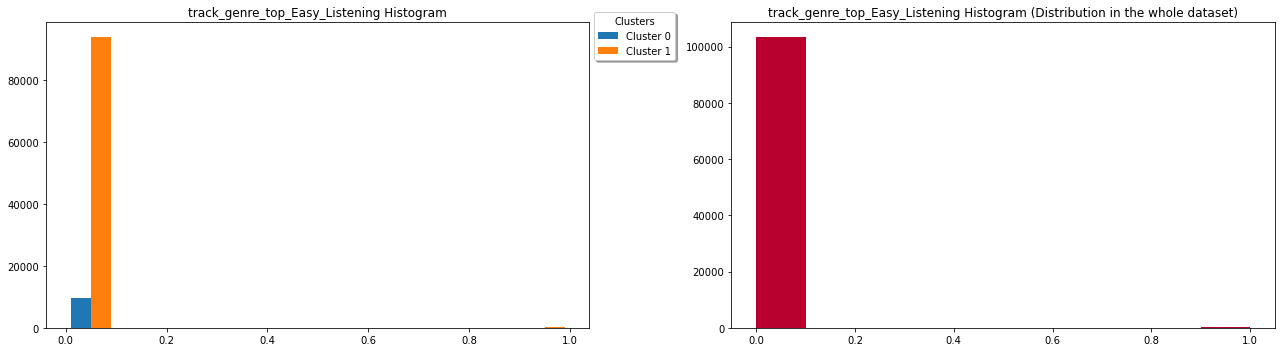

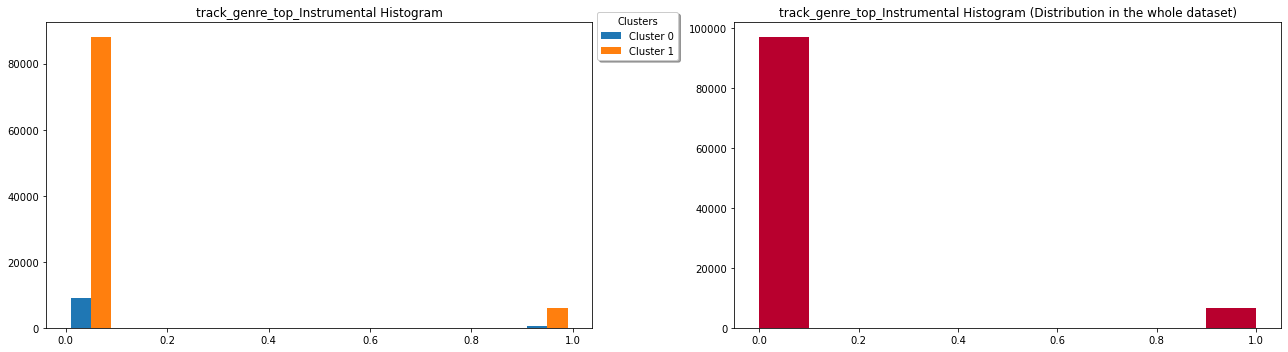

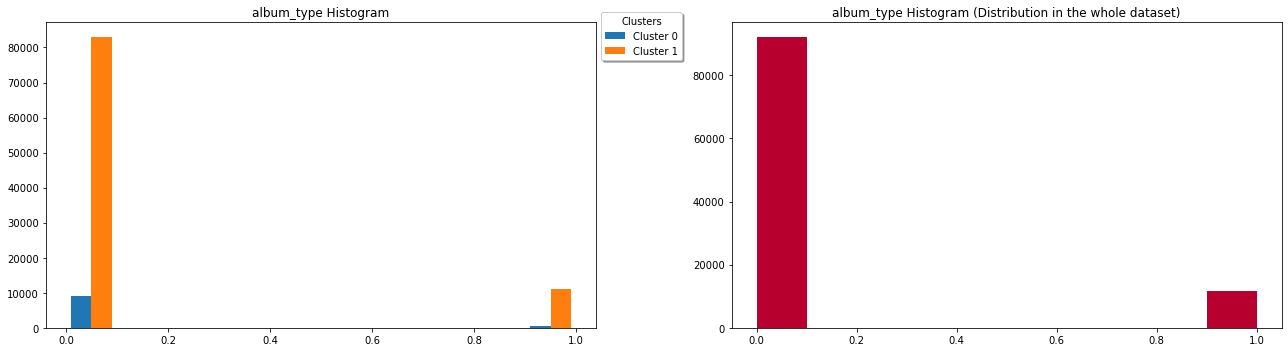

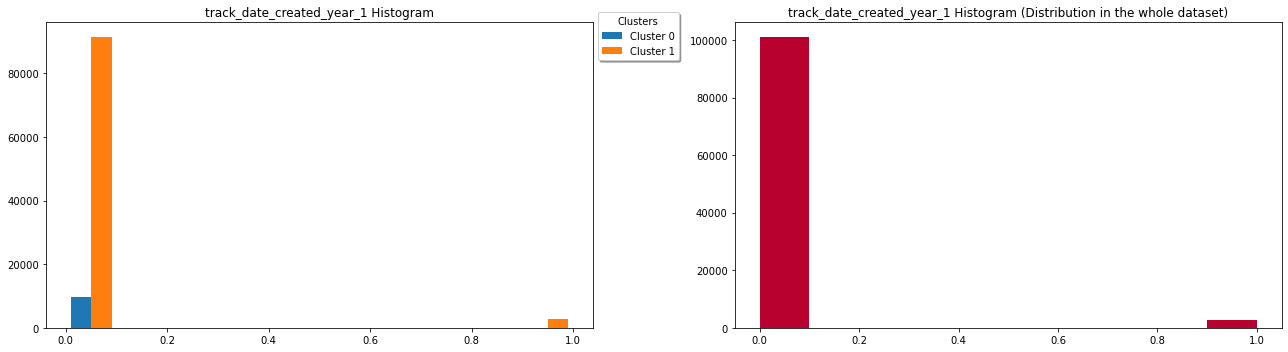

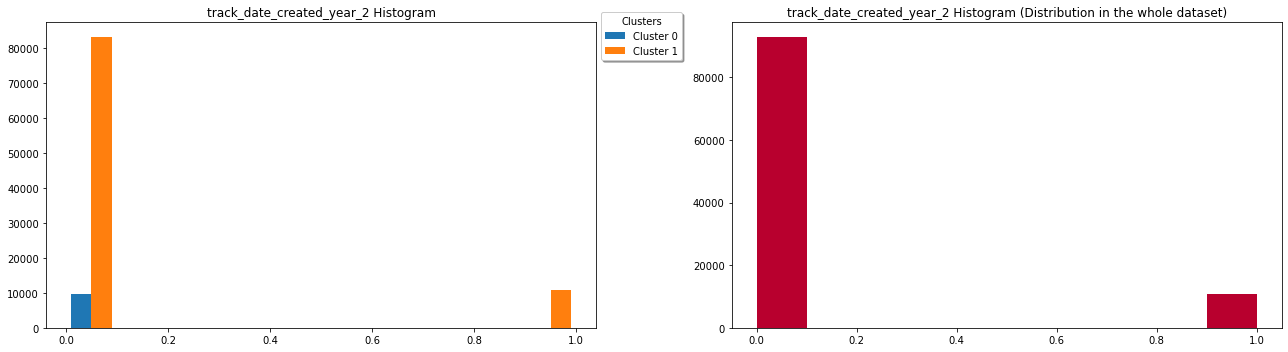

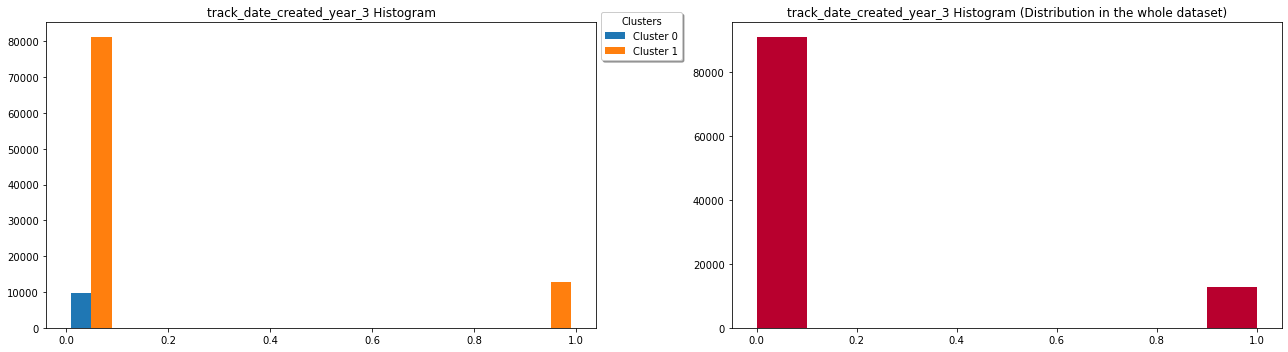

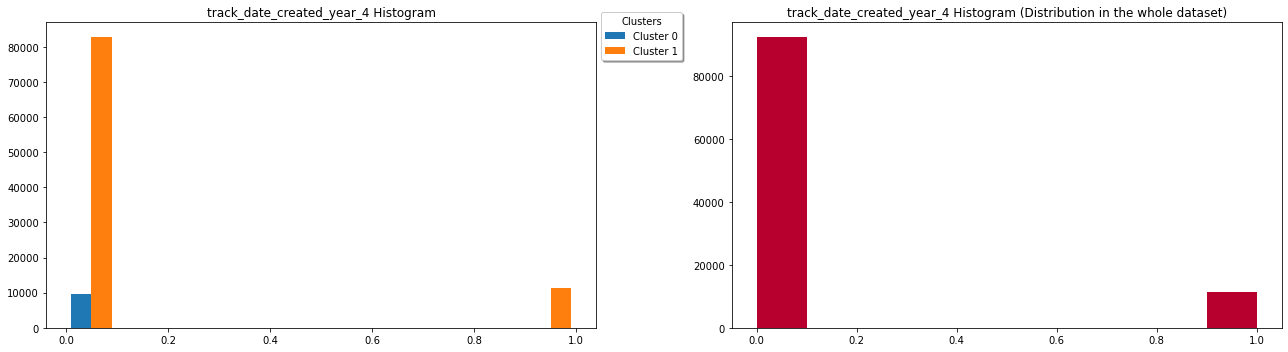

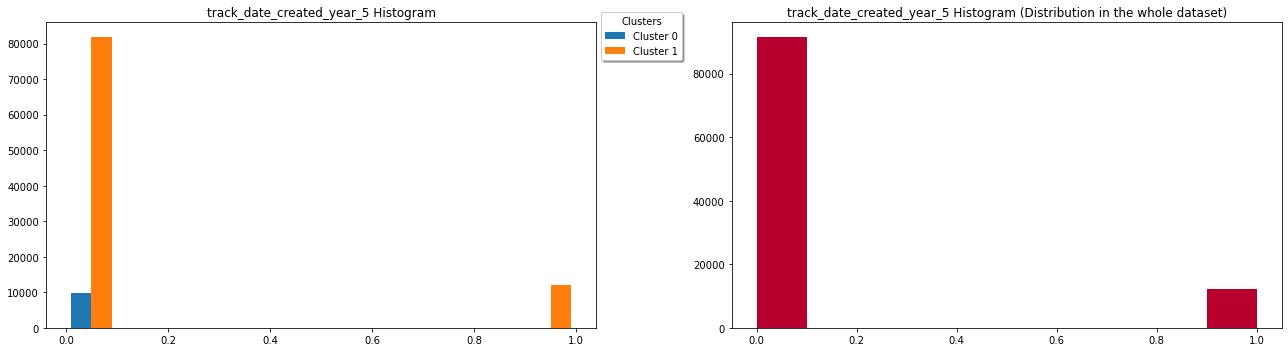

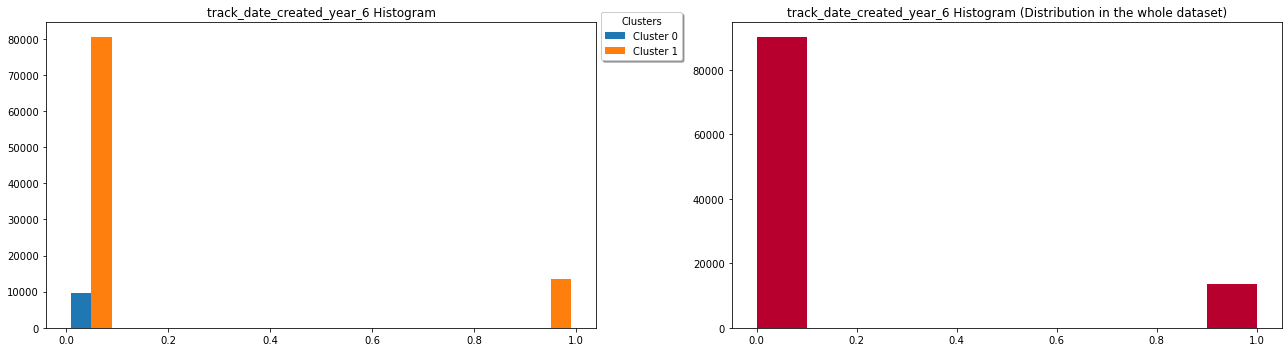

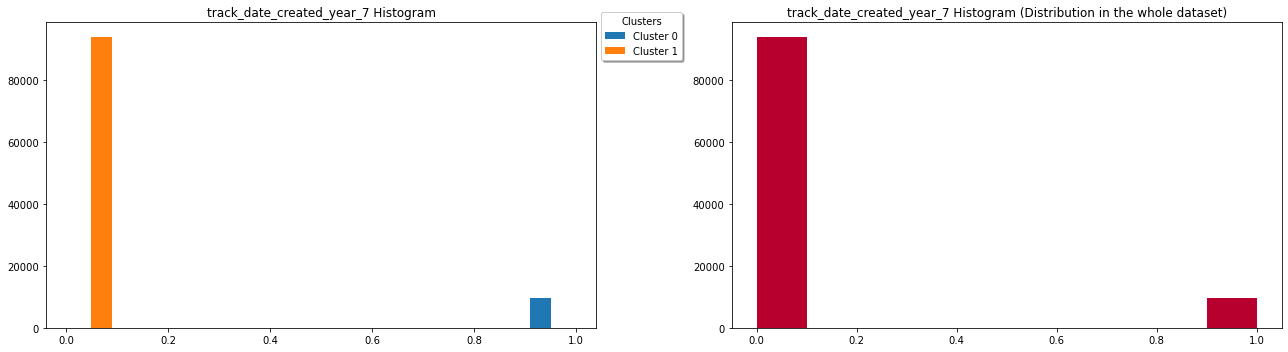

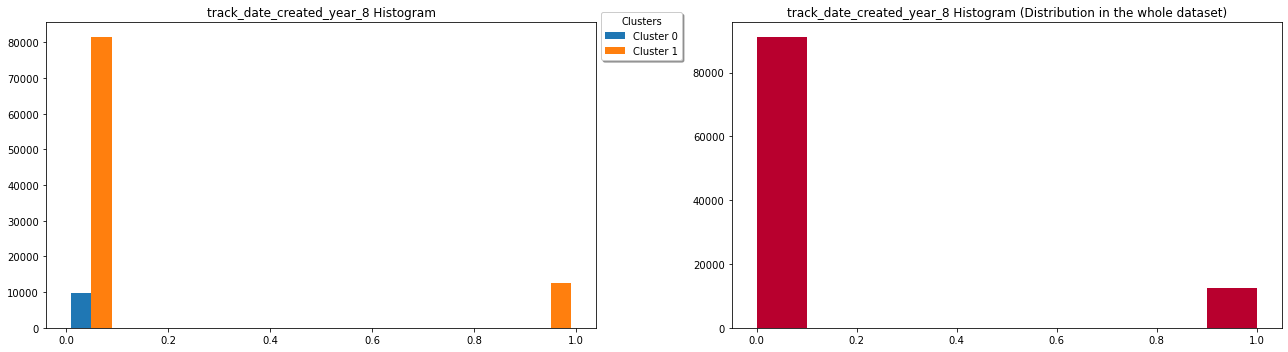

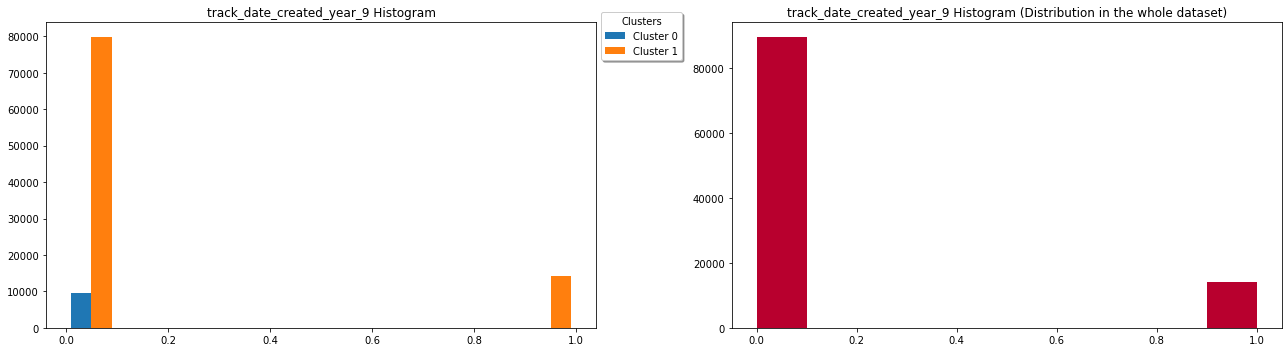

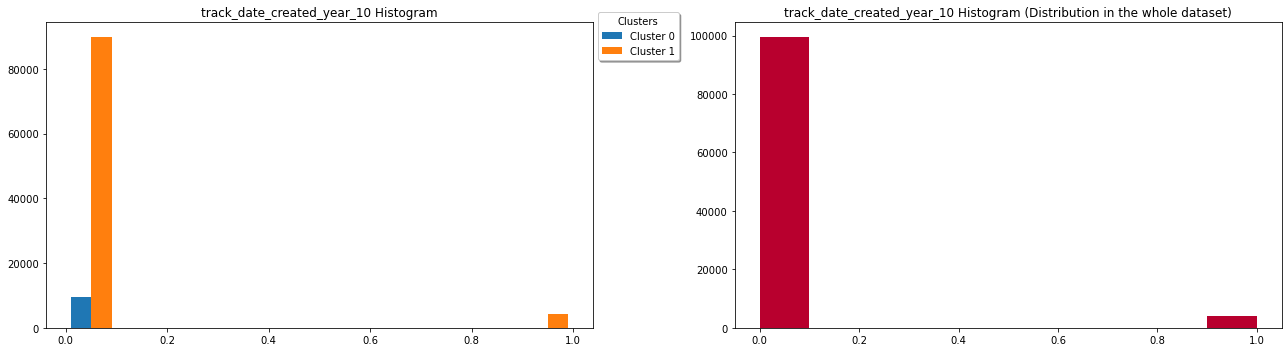

In [58]:
plot_general_distributions(df_categorical_2)

Cluster 0



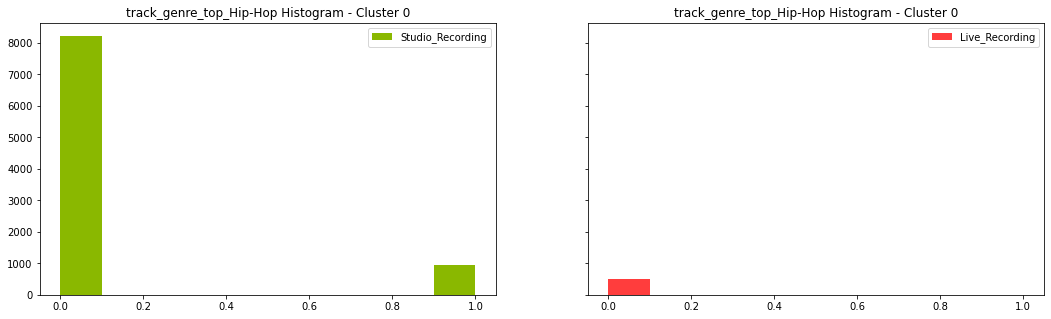

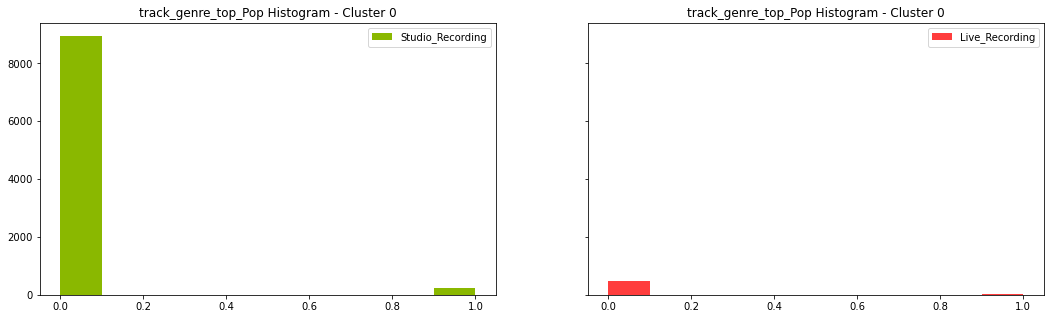

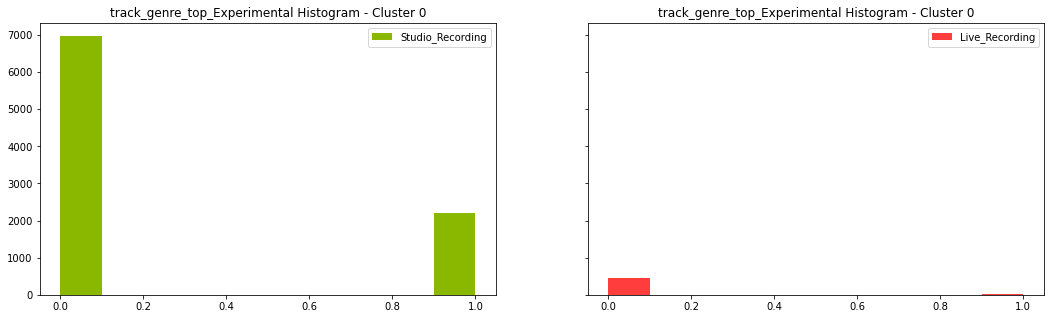

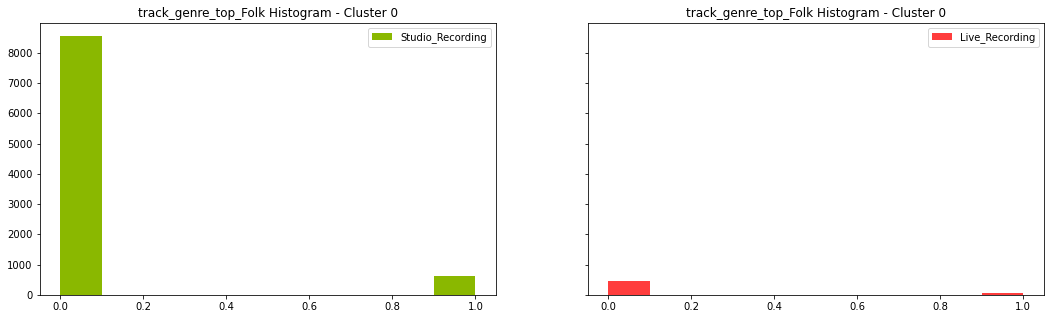

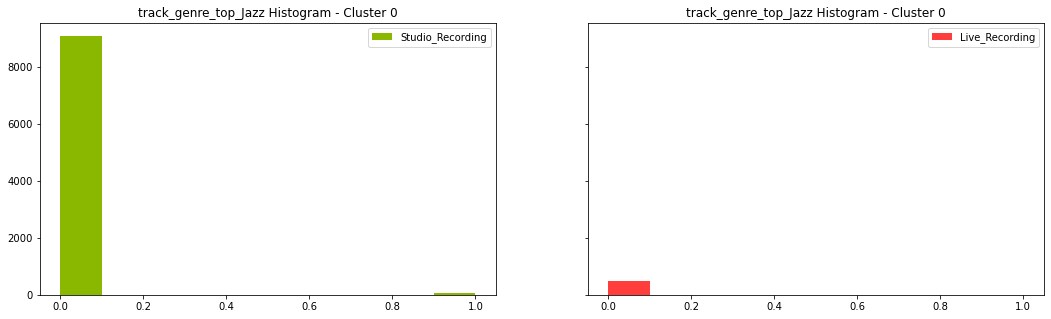

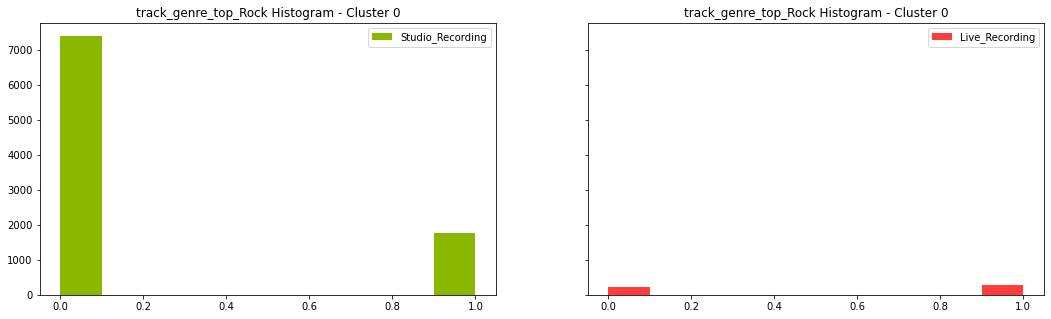

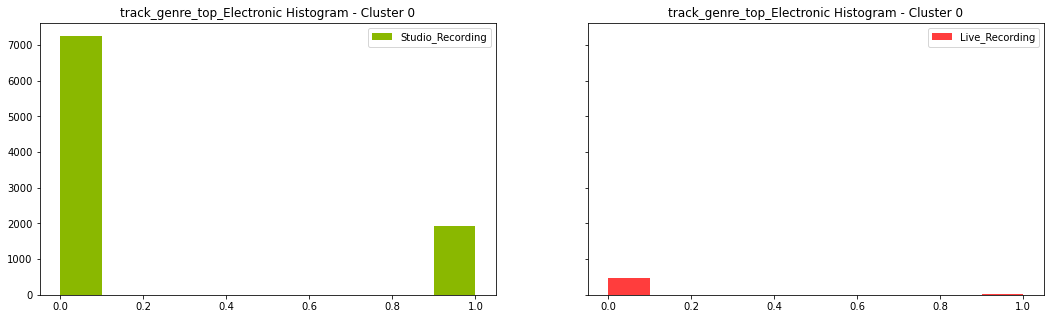

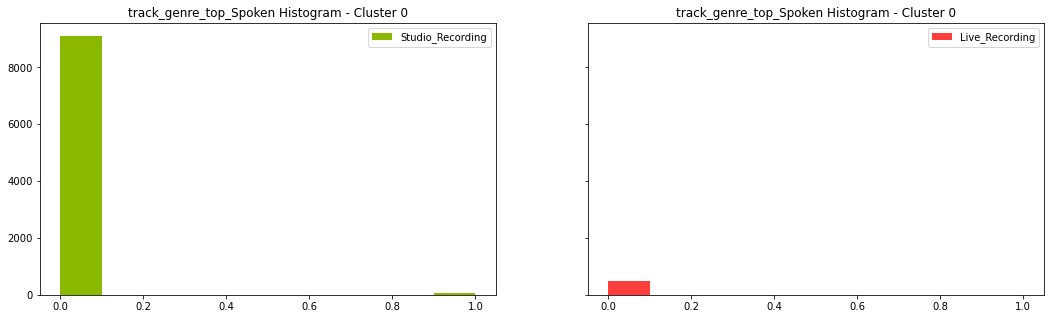

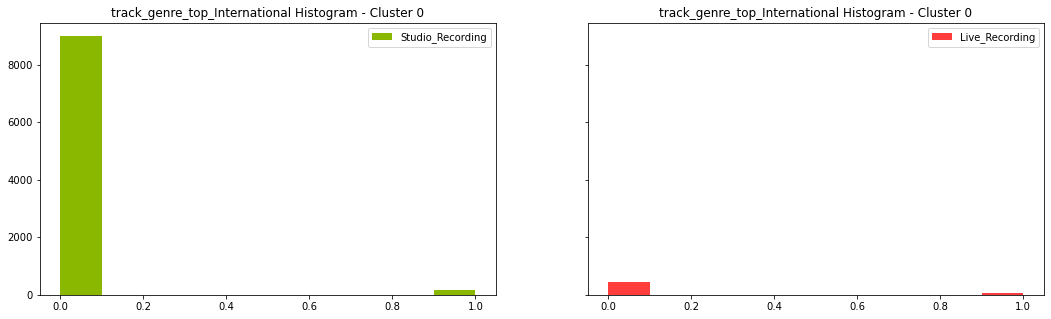

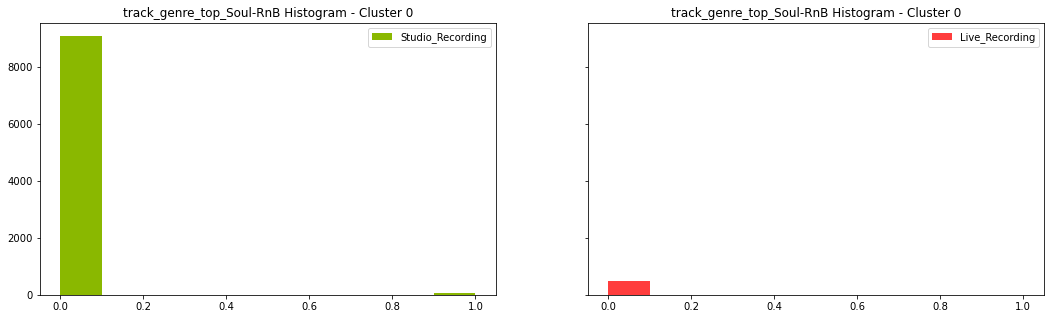

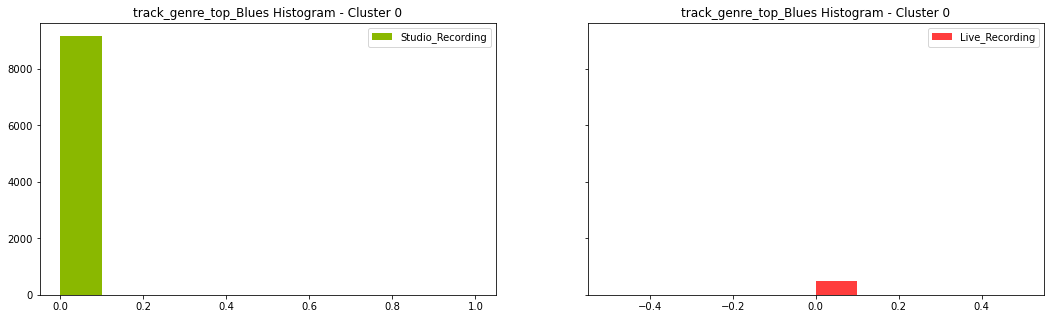

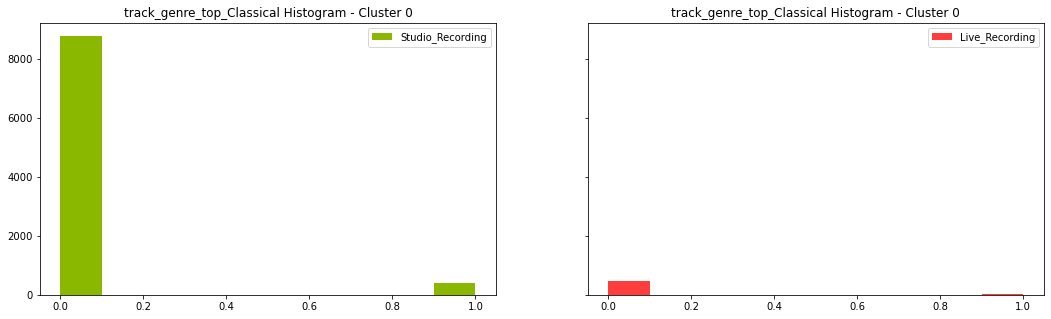

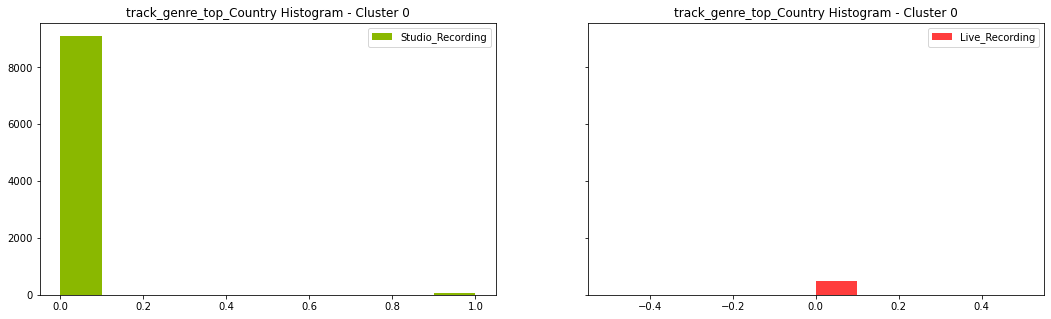

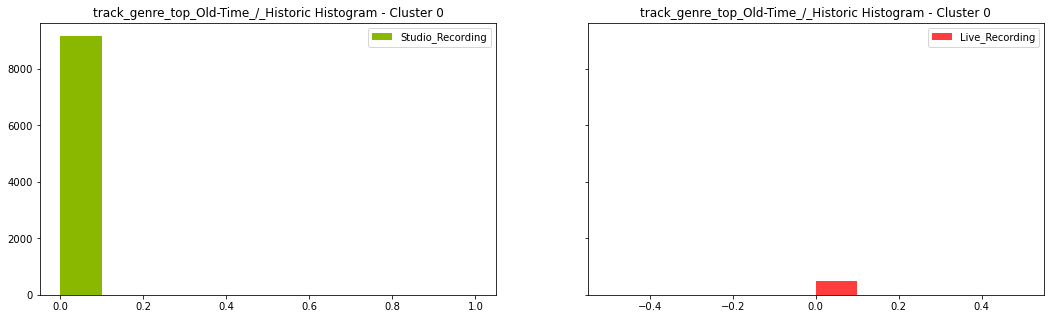

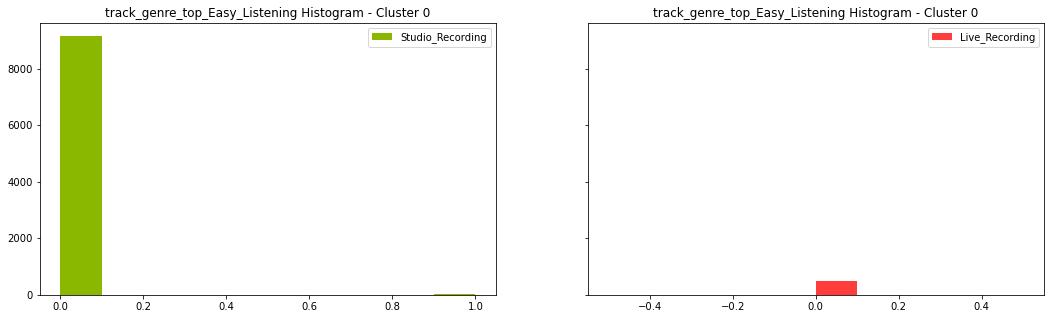

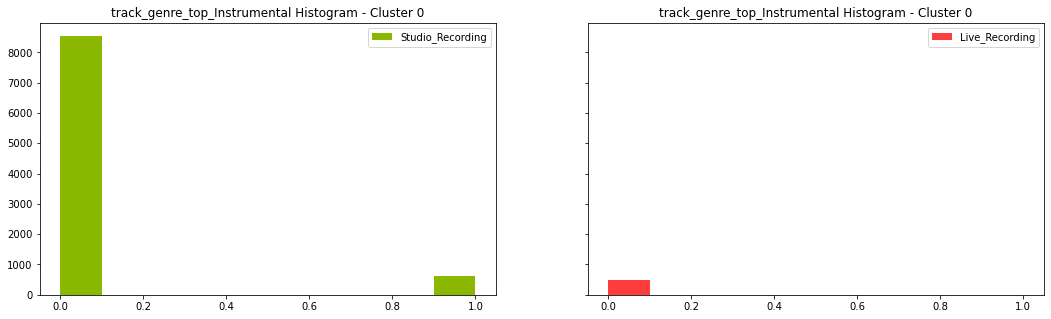

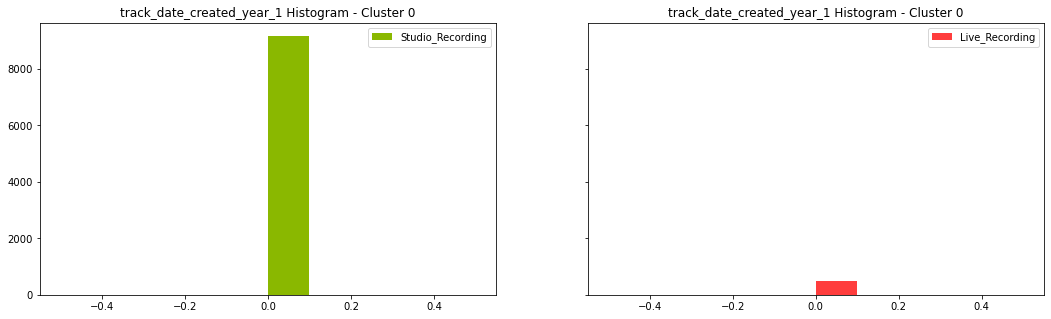

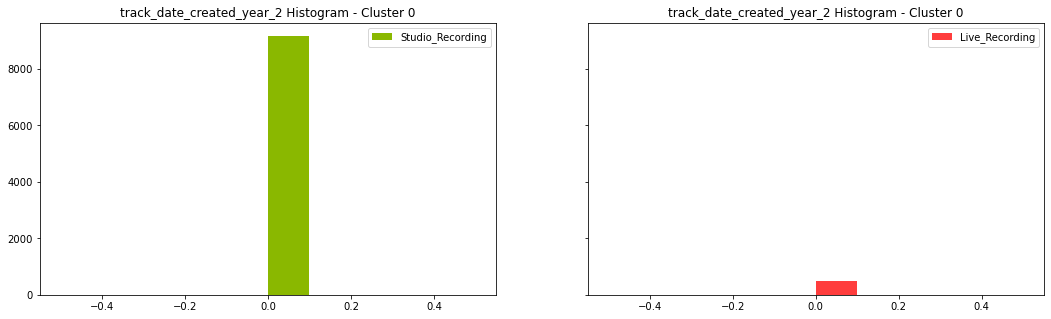

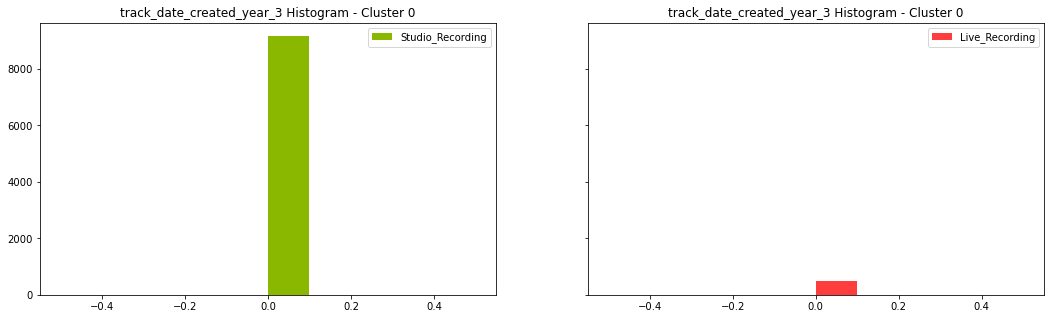

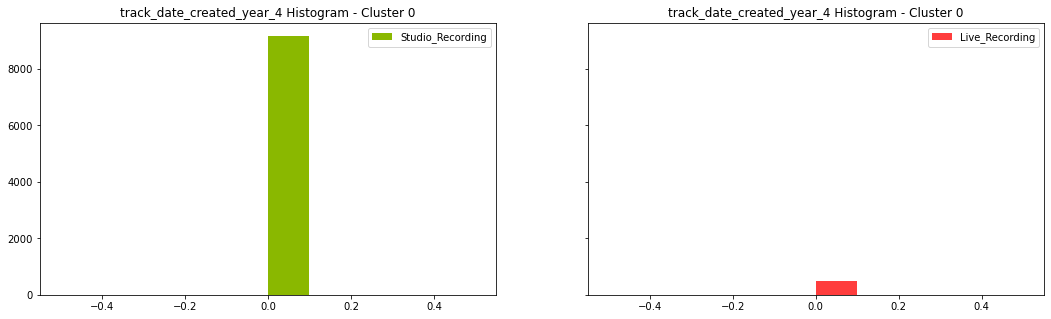

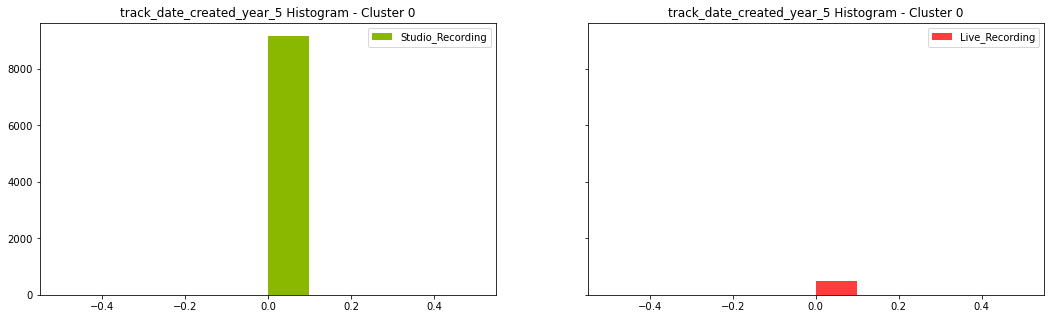

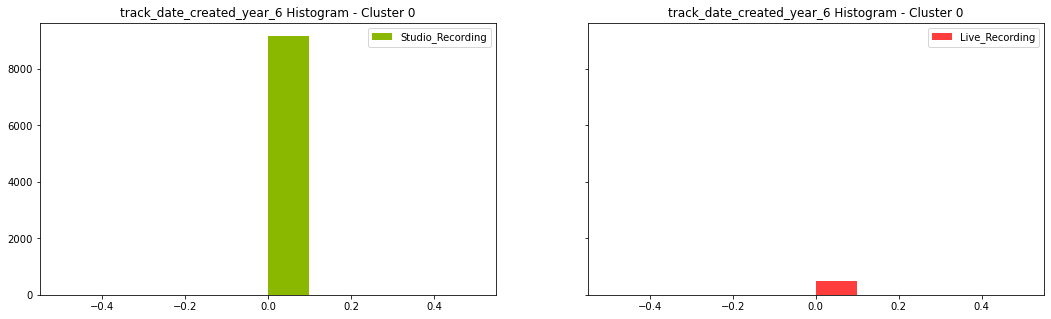

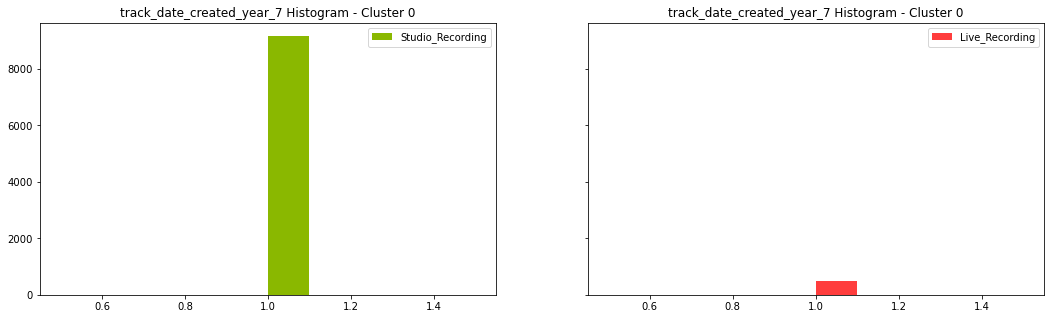

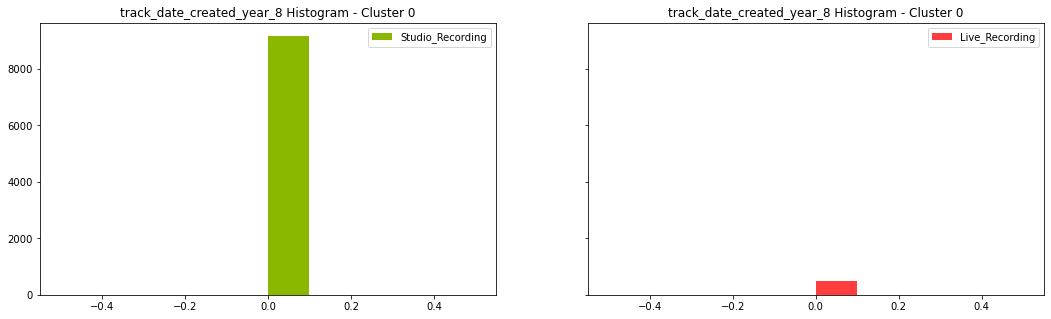

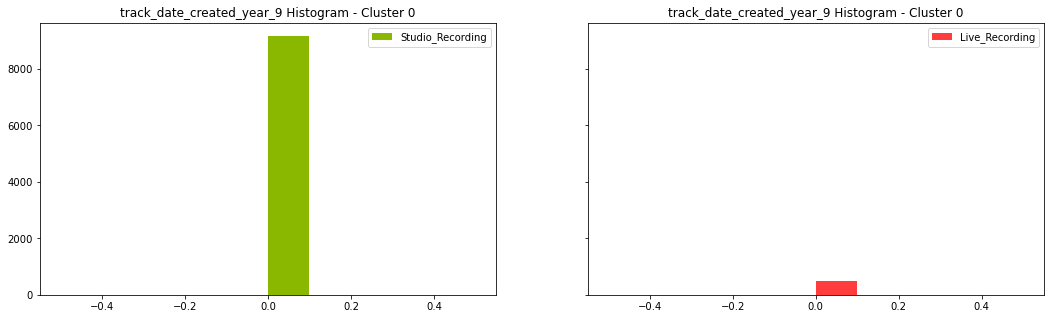

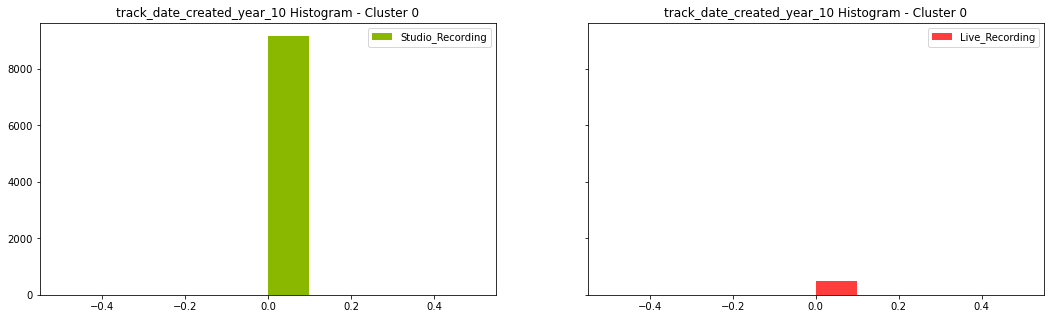

------------------------------------------------------------------------------------------------------------------
Cluster 1



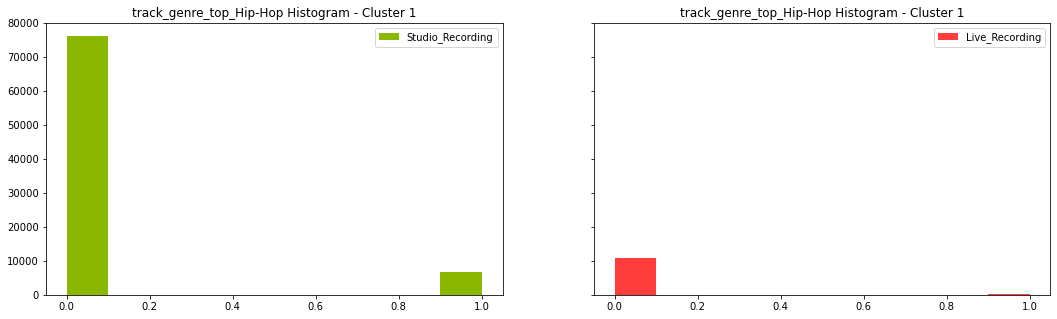

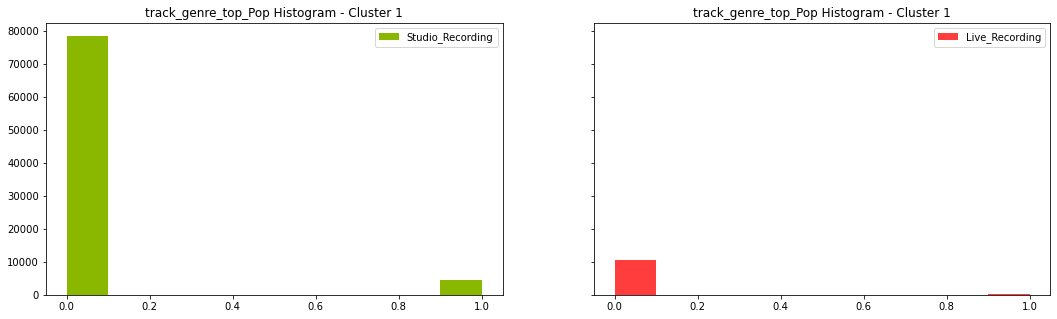

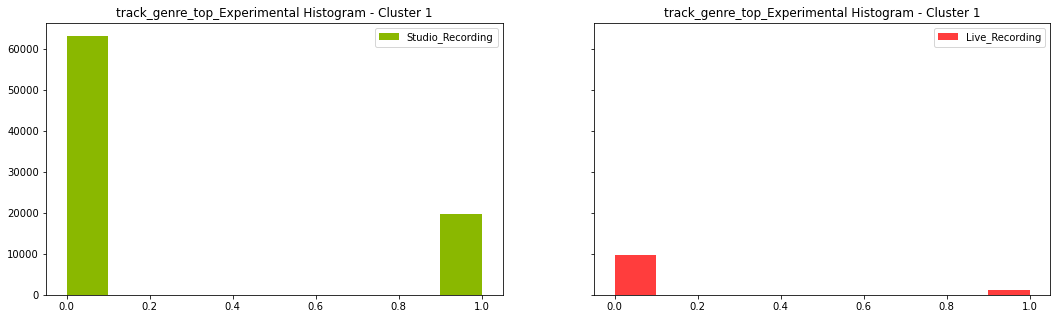

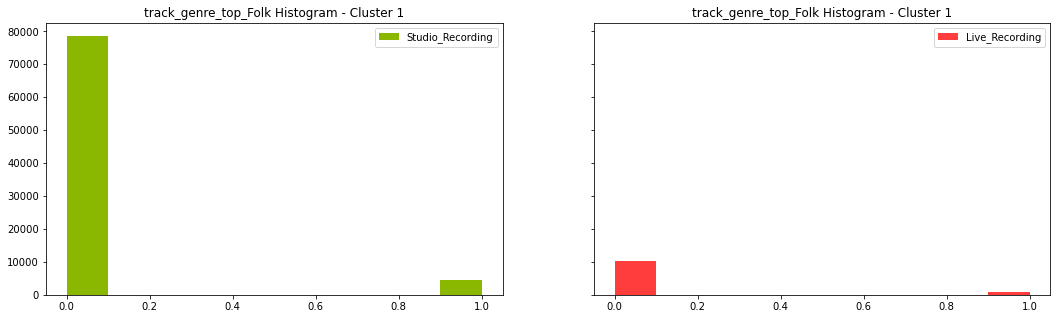

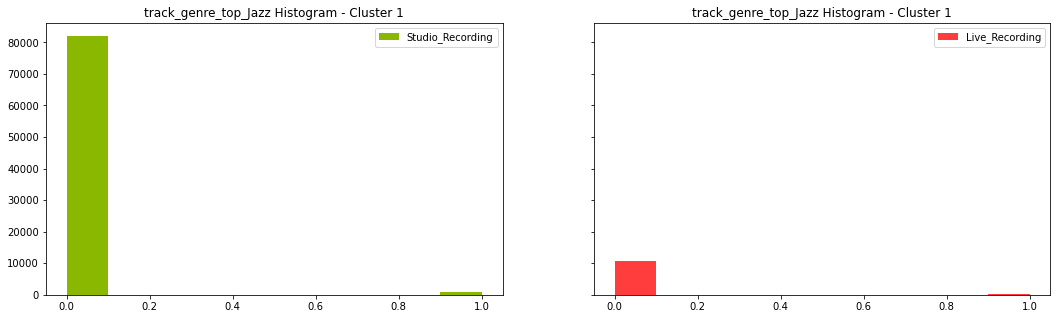

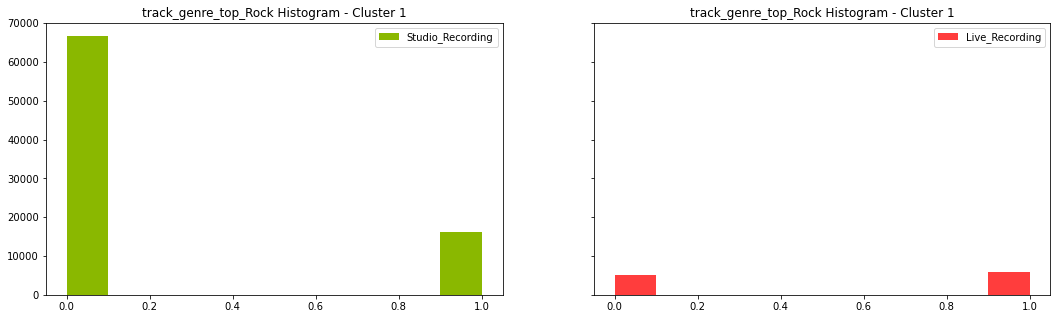

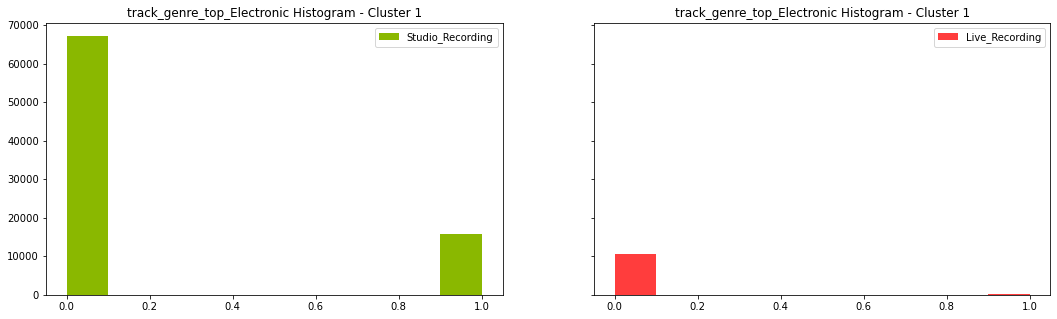

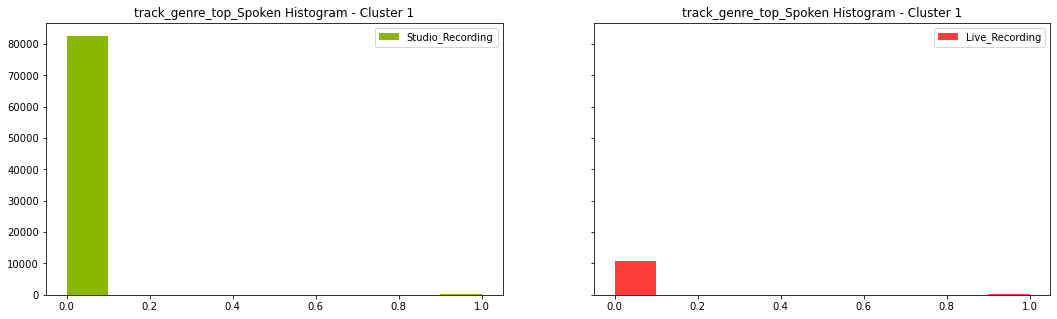

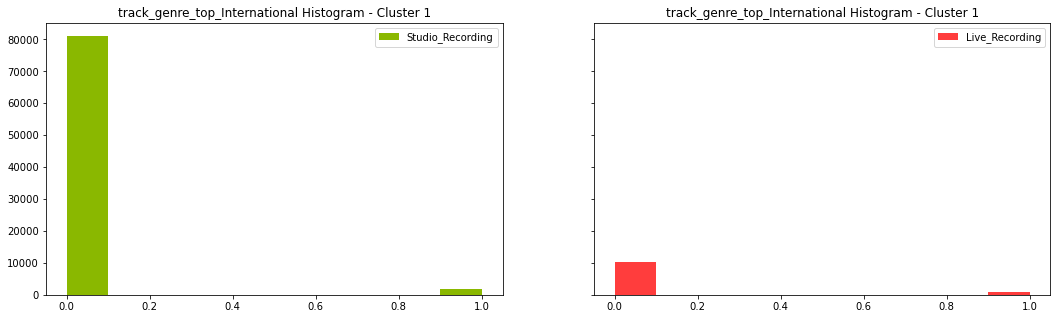

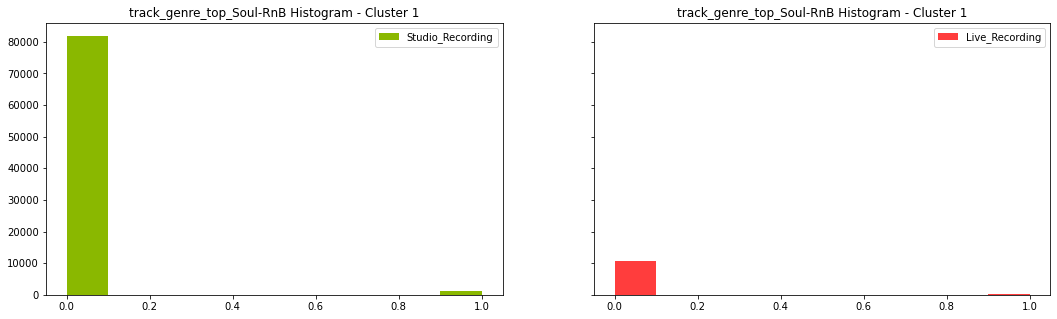

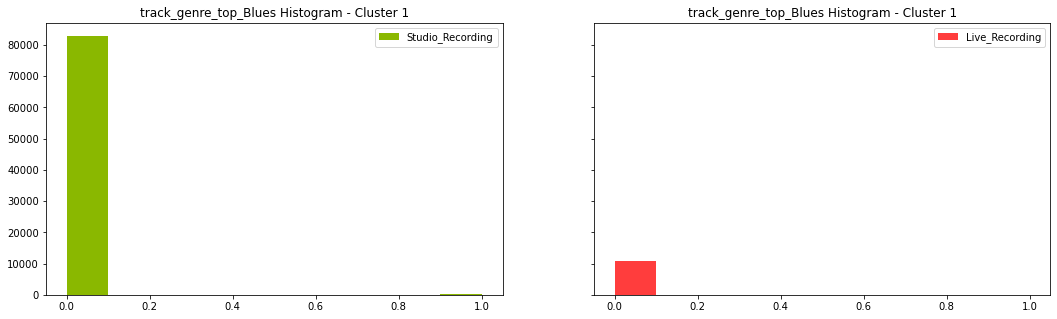

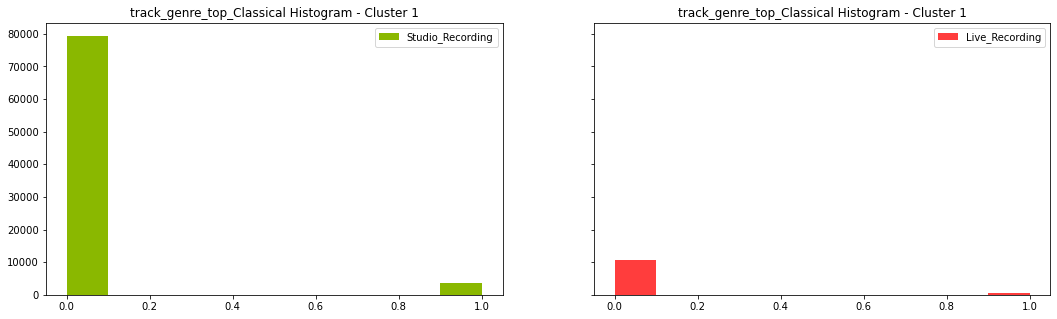

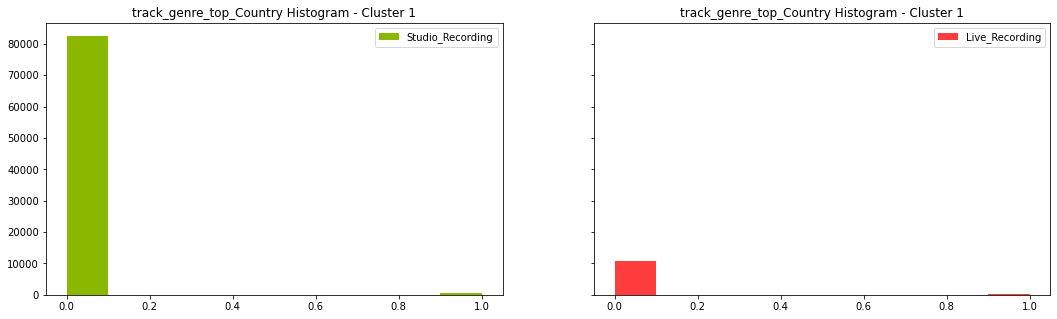

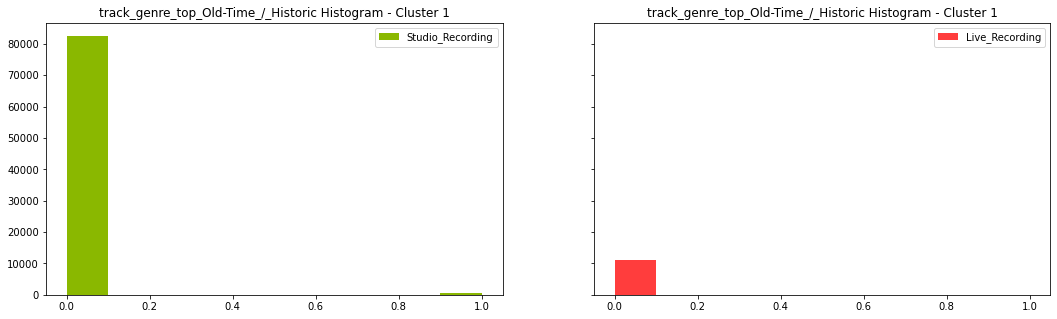

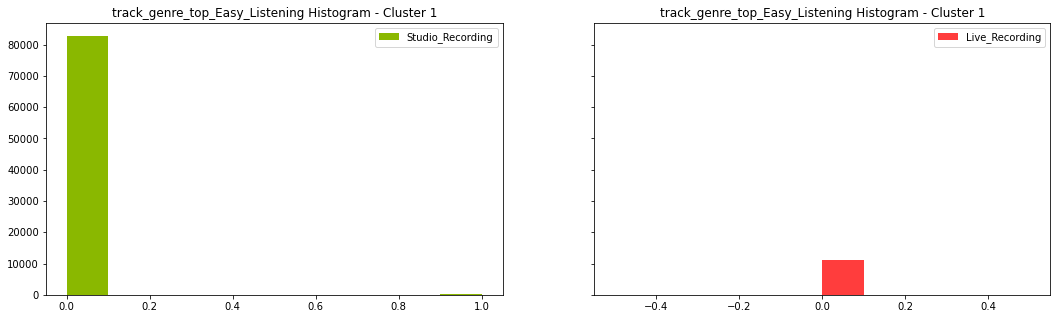

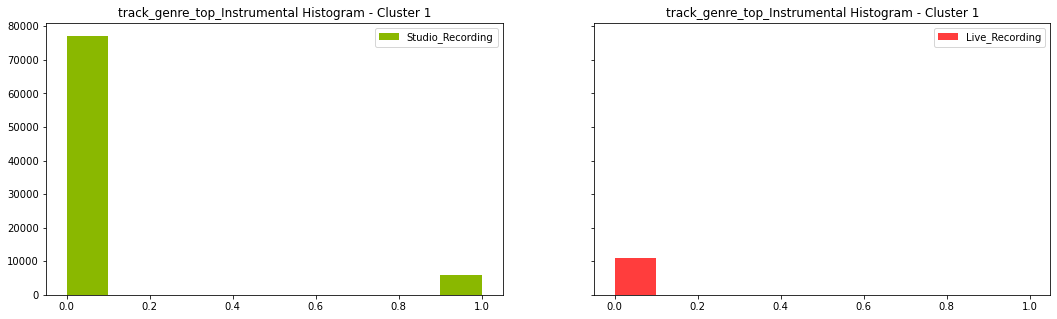

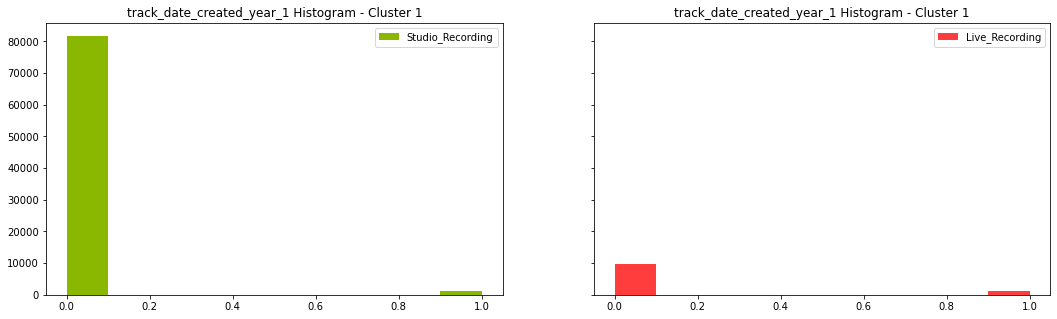

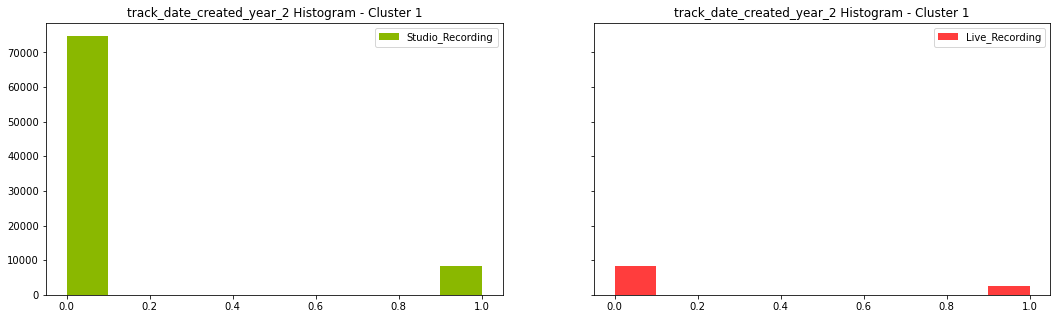

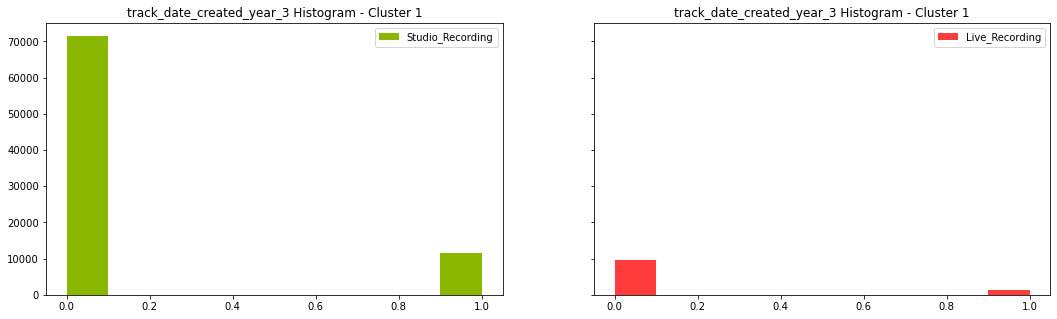

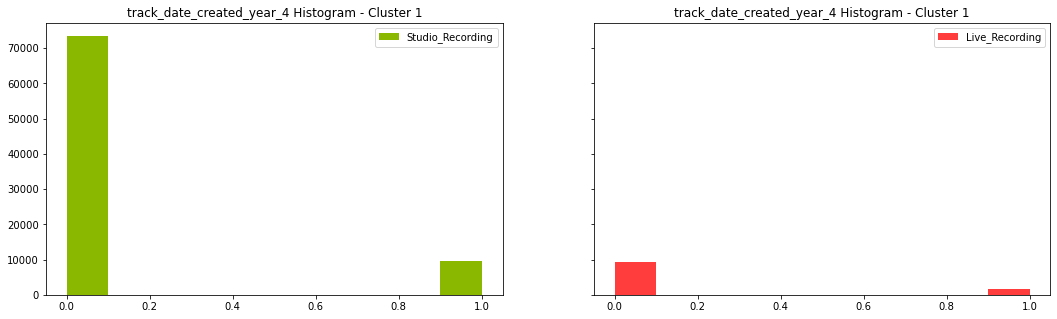

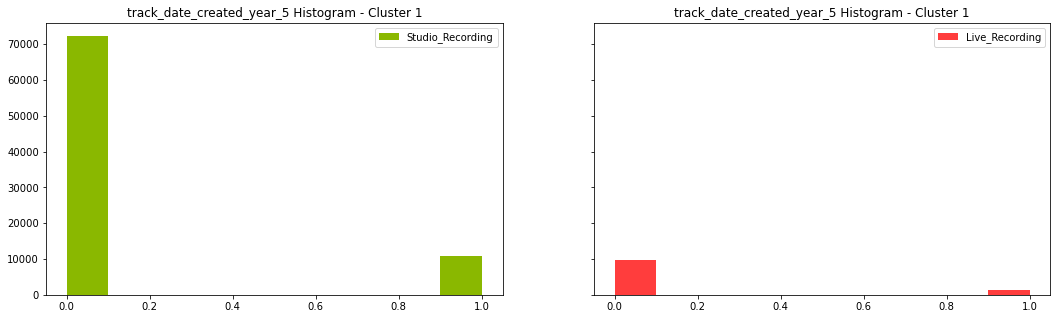

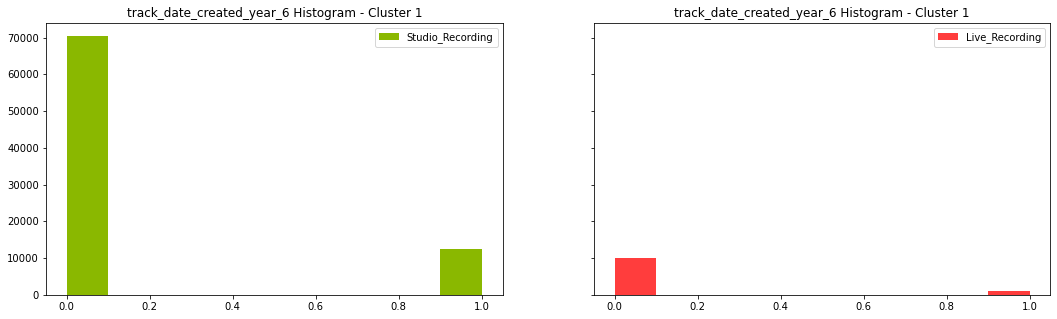

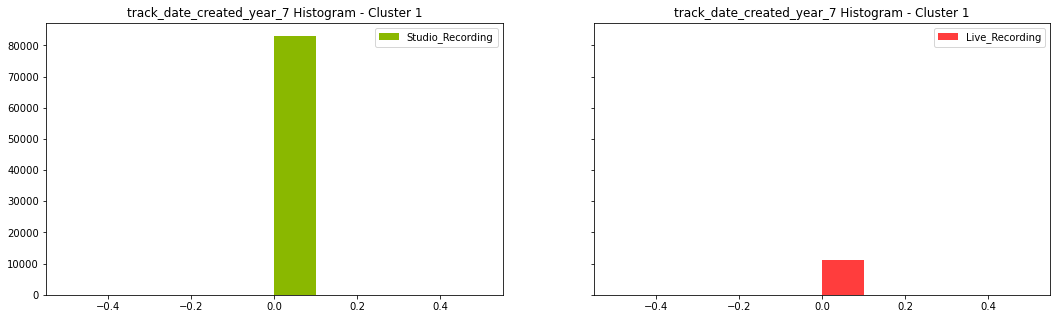

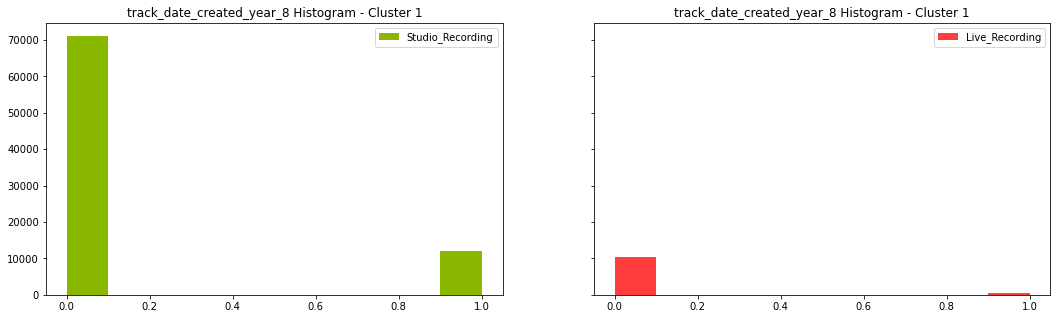

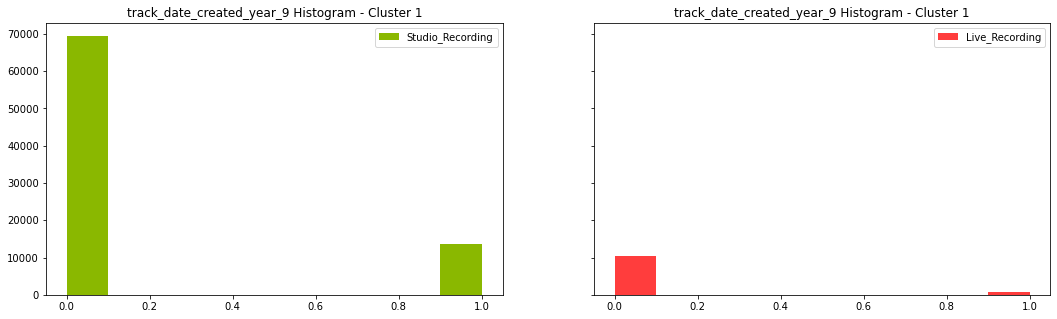

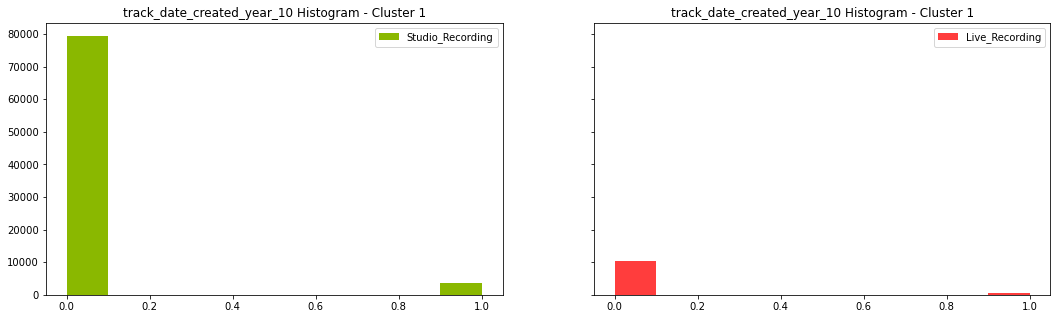

------------------------------------------------------------------------------------------------------------------


In [59]:
analyze_single_clusters(df_categorical_2)